# Ethereum Code Chunking Analysis

This notebook analyzes code chunking patterns on Ethereum mainnet to understand:
- How much of contract bytecode is actually accessed during execution
- Chunk utilization patterns across different contracts
- Chunk efficiency analysis - how many bytes were actually used within accessed chunks
- Relationships between contract characteristics and access patterns

## Updated Dataset Schema (New Format)
- `block_number`: Block number on Ethereum mainnet
- `address`: Contract address
- `bytecode_size`: Total size of the contract code
- `chunks_data`: Base64 encoded byte array where each byte represents a chunk (32-byte chunks), with values 0-32 indicating bytes accessed within that chunk
- `code_size_hash_count`: Count of EXTCODESIZE, EXTCODEHASH, CODEHASH and CODESIZE operations
- `code_copy_count`: Count of CODECOPY and EXTCODECOPY operations

## Derived Metrics
- `bytes_count`: Sum of all values in decoded chunks_data array
- `chunks_count`: Count of non-zero values in decoded chunks_data array  
- `code_ops_count`: code_size_hash_count + code_copy_count
- `chunk_efficiency`: Ratio of actual bytes accessed to total bytes in accessed chunks

**Note**: Total chunks = bytecode_size / 32 (chunks are 32 bytes each)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import base64
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully")

Libraries imported successfully


## 0. Data Processing Functions

In [2]:
def decode_chunks_data(chunks_data_base64):
    """
    Decode base64 chunks_data and return the byte array.
    Each byte represents a chunk with values 0-32 indicating bytes accessed.
    """
    try:
        decoded_bytes = base64.b64decode(chunks_data_base64)
        return np.frombuffer(decoded_bytes, dtype=np.uint8)
    except Exception as e:
        print(f"Error decoding chunks_data: {e}")
        return np.array([])

def calculate_derived_metrics(chunks_array):
    """
    Calculate bytes_count, chunks_count, and chunk_efficiency from chunks array.
    """
    bytes_count = np.sum(chunks_array)
    chunks_count = np.count_nonzero(chunks_array)
    
    # Calculate chunk efficiency: actual bytes accessed / total bytes in accessed chunks
    if chunks_count > 0:
        total_bytes_in_accessed_chunks = chunks_count * 32
        chunk_efficiency = bytes_count / total_bytes_in_accessed_chunks
    else:
        chunk_efficiency = 0.0
    
    return bytes_count, chunks_count, chunk_efficiency

def process_row(row):
    """
    Process a single row to add derived metrics.
    """
    chunks_array = decode_chunks_data(row['chunks_data'])
    bytes_count, chunks_count, chunk_efficiency = calculate_derived_metrics(chunks_array)
    
    return pd.Series({
        'bytes_count': bytes_count,
        'chunks_count': chunks_count,
        'chunk_efficiency': chunk_efficiency,
        'code_ops_count': row['code_size_hash_count'] + row['code_copy_count']
    })

print("Data processing functions defined successfully")


Data processing functions defined successfully


## 1. Data Loading and Initial Exploration

In [3]:
# Load both datasets and merge them (new format)
data_files = ['../results/analysis-0.csv', '../results/analysis-1.csv']
dataframes = []

for file_path in data_files:
    try:
        df_temp = pd.read_csv(file_path)
        print(f"Loaded {file_path}: {df_temp.shape}")
        dataframes.append(df_temp)
    except FileNotFoundError:
        print(f"Warning: {file_path} not found, skipping...")

# Merge all dataframes
df_raw = pd.concat(dataframes, ignore_index=True)

print(f"\nCombined raw dataset shape: {df_raw.shape}")
print(f"\nRaw dataset info:")
print(df_raw.info())
print(f"\nFirst few rows of raw data:")
print(df_raw.head(3))

# Process the data to add derived metrics
print("\nProcessing chunks_data to derive metrics...")
print("This may take a moment for large datasets...")

# Apply processing function to derive metrics
derived_metrics = df_raw.apply(process_row, axis=1)

# Combine original and derived data
df = pd.concat([df_raw, derived_metrics], axis=1)

print(f"\nProcessed dataset shape: {df.shape}")
print(f"\nProcessed dataset info:")
print(df.info())
print(f"\nFirst few rows with derived metrics:")
df.head(5)

Loaded ../results/analysis-0.csv: (1252986, 6)
Loaded ../results/analysis-1.csv: (1207497, 6)

Combined raw dataset shape: (2460483, 6)

Raw dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460483 entries, 0 to 2460482
Data columns (total 6 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   block_number          int64 
 1   address               object
 2   bytecode_size         int64 
 3   chunks_data           object
 4   code_size_hash_count  int64 
 5   code_copy_count       int64 
dtypes: int64(4), object(2)
memory usage: 112.6+ MB
None

First few rows of raw data:
   block_number                                     address  bytecode_size  \
0      22000000  0x000000000022D473030F116dDEE9F6B43aC78BA3           9152   
1      22000000  0x00000000009E50a7dDb7a7B0e2ee6604fd120E49          16842   
2      22000000  0x27E141dD285fE00D52AAaBF6aef1Db34745173bA           8516   

                                         chunks_data  code_siz

,block_number,address,bytecode_size,chunks_data,code_size_hash_count,code_copy_count,bytes_count,chunks_count,chunk_efficiency,code_ops_count
0,22000000,0x000000000022D473030F116dDEE9F6B43aC78BA3,9152,HCAgCwAAAAAAAAAAAAAAAAAAAAAAAAADAAAAAAAAAAAAAA...,4,0,1953,77,0.792614,4
1,22000000,0x00000000009E50a7dDb7a7B0e2ee6604fd120E49,16842,IBwgCwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,1,0,449,18,0.779514,1
2,22000000,0x27E141dD285fE00D52AAaBF6aef1Db34745173bA,8516,ICAgICAcAAAAAAAAAB0eAAkAAAAAAAAAAAAAAAIgICAgIB...,0,0,2180,85,0.801471,0
3,22000000,0xEfC814a4C676a7314a13954e283dE6CEF597e6b2,7864,HAsAAAAMAAwgAQAAAyANAAAAAAAAAAAAAAAAAAAAAAAAAA...,0,0,1531,63,0.759425,0
4,22000000,0xE86DF1970055e9CaEe93Dae9B7D5fD71595d0e18,7567,HCABAAAAAAAAAAAAAAAAAAAAAAAADyABAAAAAAAAAAAAAA...,0,0,974,42,0.724702,0


## 2. Data Cleaning

In [6]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check for empty rows (all NaN)
empty_rows = df.isnull().all(axis=1).sum()
print(f"\nEmpty rows: {empty_rows}")

# Remove any empty rows and rows with invalid chunks_data
print("Checking for invalid chunks_data...")
invalid_chunks = df['chunks_data'].isna() | (df['chunks_data'] == '')
print(f"Invalid chunks_data entries: {invalid_chunks.sum()}")

df_clean = df.dropna(how='all').copy()
if invalid_chunks.sum() > 0:
    df_clean = df_clean[~invalid_chunks].copy()
print(f"Shape after removing empty/invalid rows: {df_clean.shape}")

Missing values per column:
block_number            0
address                 0
bytecode_size           0
chunks_data             0
code_size_hash_count    0
code_copy_count         0
bytes_count             0
chunks_count            0
chunk_efficiency        0
code_ops_count          0
dtype: int64

Empty rows: 0
Checking for invalid chunks_data...
Invalid chunks_data entries: 0
Shape after removing empty/invalid rows: (2460483, 10)


In [7]:
# Check for duplicate (block_number, address) combinations
duplicates = df_clean.duplicated(subset=['block_number', 'address']).sum()
print(f"Duplicate block_number + address combinations: {duplicates}")

if duplicates > 0:
    print("\nDuplicate entries:")
    duplicate_mask = df_clean.duplicated(subset=['block_number', 'address'], keep=False)
    print(df_clean[duplicate_mask].sort_values(['block_number', 'address']))
    
    # Keep first occurrence of duplicates
    df_clean = df_clean.drop_duplicates(subset=['block_number', 'address'], keep='first')
    print(f"\nShape after removing duplicates: {df_clean.shape}")
else:
    print("No duplicates found - data is clean!")

Duplicate block_number + address combinations: 162

Duplicate entries:
         block_number                                     address  \
1252812      22005000  0x0000000000001fF3684f28c67538d4D072C22734   
1252824      22005000  0x0000000000001fF3684f28c67538d4D072C22734   
1252705      22005000  0x000000000022D473030F116dDEE9F6B43aC78BA3   
1252873      22005000  0x000000000022D473030F116dDEE9F6B43aC78BA3   
1252715      22005000  0x00000000009726632680FB29d3F7A9734E3010E2   
...               ...                                         ...   
1252974      22005000  0xfAaE2946e846133af314d1Df13684c89fA7d83DD   
1252670      22005000  0xfE9AB78eD4f9f3DbB168d9f5E5213d78605C9805   
1252953      22005000  0xfE9AB78eD4f9f3DbB168d9f5E5213d78605C9805   
1252795      22005000  0xfbEedCFe378866DaB6abbaFd8B2986F5C1768737   
1252931      22005000  0xfbEedCFe378866DaB6abbaFd8B2986F5C1768737   

         bytecode_size                                        chunks_data  \
1252812           1009 

In [8]:
# Check for any data quality issues
print("Data Quality Checks:")
print(f"Records with bytecode_size = 0: {(df_clean['bytecode_size'] == 0).sum()}")
print(f"Records with bytes_count > bytecode_size: {(df_clean['bytes_count'] > df_clean['bytecode_size']).sum()}")
print(f"Records with chunk_efficiency > 1.0: {(df_clean['chunk_efficiency'] > 1.0).sum()}")
print(f"Records with chunk_efficiency < 0.0: {(df_clean['chunk_efficiency'] < 0.0).sum()}")

# Check derived metrics consistency
print(f"\nDerived Metrics Validation:")
print(f"Records where code_ops_count != code_size_hash_count + code_copy_count: {(df_clean['code_ops_count'] != (df_clean['code_size_hash_count'] + df_clean['code_copy_count'])).sum()}")

# Check chunk efficiency calculation validity
# For non-zero chunk counts, efficiency should be between 0 and 1
non_zero_chunks = df_clean[df_clean['chunks_count'] > 0]
if len(non_zero_chunks) > 0:
    invalid_efficiency = (non_zero_chunks['chunk_efficiency'] < 0) | (non_zero_chunks['chunk_efficiency'] > 1)
    print(f"Records with invalid chunk efficiency (should be 0-1): {invalid_efficiency.sum()}")

# Check block range (should include blocks 22000000 to 22010000 inclusive)
print(f"\nBlock Range Analysis:")
print(f"Block range in data: {df_clean['block_number'].min()} - {df_clean['block_number'].max()}")
print(f"Expected range: 22000000 - 22010000")

# Validate expected block range
expected_min_block = 22000000
expected_max_block = 22010000
actual_min_block = df_clean['block_number'].min()
actual_max_block = df_clean['block_number'].max()

blocks_in_expected_range = df_clean[
    (df_clean['block_number'] >= expected_min_block) & 
    (df_clean['block_number'] <= expected_max_block)
]

print(f"\nBlock Range Validation:")
print(f"Records in expected range (22000000-22010000): {len(blocks_in_expected_range)} ({len(blocks_in_expected_range)/len(df_clean)*100:.1f}%)")

# Detailed block analysis
expected_block_count = expected_max_block - expected_min_block + 1
actual_unique_blocks = df_clean['block_number'].nunique()
print(f"\nDetailed Block Analysis:")
print(f"Expected total blocks: {expected_block_count:,}")
print(f"Actual unique blocks: {actual_unique_blocks:,}")
print(f"Missing blocks: {expected_block_count - actual_unique_blocks}")

if expected_block_count != actual_unique_blocks:
    # Find missing blocks
    expected_blocks = set(range(expected_min_block, expected_max_block + 1))
    actual_blocks = set(df_clean['block_number'].unique())
    missing_blocks = sorted(expected_blocks - actual_blocks)
    
    print(f"\n❌ Missing blocks ({len(missing_blocks)}):")
    if len(missing_blocks) <= 20:  # Only show if reasonable number
        print(f"   {missing_blocks}")
    else:
        print(f"   First 10: {missing_blocks[:10]}")
        print(f"   Last 10: {missing_blocks[-10:]}")
        
    # Check for any blocks outside expected range
    extra_blocks = sorted(actual_blocks - expected_blocks)
    if extra_blocks:
        print(f"\n⚠️  Blocks outside expected range ({len(extra_blocks)}):")
        if len(extra_blocks) <= 20:
            print(f"   {extra_blocks}")
        else:
            print(f"   First 10: {extra_blocks[:10]}")
            print(f"   Last 10: {extra_blocks[-10:]}")

if actual_min_block < expected_min_block or actual_max_block > expected_max_block:
    print(f"⚠️  Warning: Data contains blocks outside expected range")
    
if len(blocks_in_expected_range) == 0:
    print(f"❌ Error: No blocks found in expected range!")
else:
    print(f"✅ Data contains blocks in expected range")

# Block coverage statistics
block_counts = df_clean['block_number'].value_counts().sort_index()
print(f"\nBlock Coverage Statistics:")
print(f"Min contracts per block: {block_counts.min()}")
print(f"Max contracts per block: {block_counts.max()}")
print(f"Median contracts per block: {block_counts.median():.1f}")
print(f"Blocks with 0 contracts: {expected_block_count - actual_unique_blocks}")
print("Missing blocks have 0 contract-related transactions (manually checked)")

# Show distribution of contracts per block
print(f"\nContract Distribution Summary:")
print(f"Blocks with <100 contracts: {(block_counts < 100).sum()}")
print(f"Blocks with 100-500 contracts: {((block_counts >= 100) & (block_counts < 500)).sum()}")
print(f"Blocks with 500+ contracts: {(block_counts >= 500).sum()}")

# Remove records with bytecode_size = 0 as they're not meaningful for analysis
df_clean = df_clean[df_clean['bytecode_size'] > 0]
print(f"\nFinal cleaned dataset shape: {df_clean.shape}")

# Additional validation for large dataset
print(f"\nDataset Scale:")
print(f"Total contracts: {len(df_clean):,}")
print(f"Unique addresses: {df_clean['address'].nunique():,}")
print(f"Average contracts per block: {len(df_clean) / df_clean['block_number'].nunique():.1f}")

Data Quality Checks:
Records with bytecode_size = 0: 0
Records with bytes_count > bytecode_size: 0
Records with chunk_efficiency > 1.0: 0
Records with chunk_efficiency < 0.0: 0

Derived Metrics Validation:
Records where code_ops_count != code_size_hash_count + code_copy_count: 0
Records with invalid chunk efficiency (should be 0-1): 0

Block Range Analysis:
Block range in data: 22000000 - 22010000
Expected range: 22000000 - 22010000

Block Range Validation:
Records in expected range (22000000-22010000): 2460321 (100.0%)

Detailed Block Analysis:
Expected total blocks: 10,001
Actual unique blocks: 9,993
Missing blocks: 8

❌ Missing blocks (8):
   [22000150, 22000719, 22001061, 22002405, 22004951, 22006220, 22006786, 22006898]
✅ Data contains blocks in expected range

Block Coverage Statistics:
Min contracts per block: 3
Max contracts per block: 649
Median contracts per block: 239.0
Blocks with 0 contracts: 8
Missing blocks have 0 contract-related transactions (manually checked)

Contrac

## 3. Chunk Efficiency Analysis

In [19]:
# Detailed chunk efficiency analysis
print("=== CHUNK EFFICIENCY ANALYSIS ===")
print("Chunk efficiency = bytes_accessed / (chunks_accessed * 32)")
print("This measures how efficiently we use the chunks we access")
print()

# Overall efficiency statistics
print("Overall Chunk Efficiency Distribution:")
print(f"Mean: {df_clean['chunk_efficiency'].mean():.4f}")
print(f"Median: {df_clean['chunk_efficiency'].median():.4f}")
print(f"Std Dev: {df_clean['chunk_efficiency'].std():.4f}")
print()

# Efficiency bins analysis
efficiency_bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
efficiency_labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', 
                    '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

df_clean['efficiency_bin'] = pd.cut(df_clean['chunk_efficiency'], 
                                  bins=efficiency_bins, 
                                  labels=efficiency_labels, 
                                  include_lowest=True)

print("Chunk Efficiency Distribution:")
efficiency_dist = df_clean['efficiency_bin'].value_counts().sort_index()
for bin_name, count in efficiency_dist.items():
    percentage = (count / len(df_clean)) * 100
    print(f"{bin_name}: {count:,} contracts ({percentage:.1f}%)")
print()

# Special cases analysis
print("Special Cases:")
perfect_efficiency = (df_clean['chunk_efficiency'] == 1.0).sum()
zero_access = (df_clean['chunks_count'] == 0).sum()
low_efficiency = (df_clean['chunk_efficiency'] < 0.1).sum()
high_efficiency = (df_clean['chunk_efficiency'] > 0.9).sum()

print(f"Perfect efficiency (100%): {perfect_efficiency:,} ({perfect_efficiency/len(df_clean)*100:.1f}%)")
print(f"No chunks accessed: {zero_access:,} ({zero_access/len(df_clean)*100:.1f}%)")
print(f"Very low efficiency (<10%): {low_efficiency:,} ({low_efficiency/len(df_clean)*100:.1f}%)")
print(f"High efficiency (>90%): {high_efficiency:,} ({high_efficiency/len(df_clean)*100:.1f}%)")


=== CHUNK EFFICIENCY ANALYSIS ===
Chunk efficiency = bytes_accessed / (chunks_accessed * 32)
This measures how efficiently we use the chunks we access

Overall Chunk Efficiency Distribution:
Mean: 0.6848
Median: 0.6875
Std Dev: 0.1024

Chunk Efficiency Distribution:
0-10%: 1,056 contracts (0.0%)
10-20%: 1 contracts (0.0%)
20-30%: 459 contracts (0.0%)
30-40%: 9,728 contracts (0.4%)
40-50%: 92,569 contracts (3.8%)
50-60%: 416,461 contracts (16.9%)
60-70%: 876,073 contracts (35.6%)
70-80%: 792,068 contracts (32.2%)
80-90%: 243,941 contracts (9.9%)
90-100%: 27,965 contracts (1.1%)

Special Cases:
Perfect efficiency (100%): 226 (0.0%)
No chunks accessed: 993 (0.0%)
Very low efficiency (<10%): 1,056 (0.0%)
High efficiency (>90%): 27,965 (1.1%)


In [20]:
# Chunk efficiency by contract size
print("=== CHUNK EFFICIENCY BY CONTRACT SIZE ===")

# Create size categories for analysis
size_bins = [0, 1023, 5119, 10239, 20479, float('inf')]
size_labels = ['Tiny (<1KiB)', 'Small (1-5KiB)', 'Medium (5-10KiB)', 
                        'Large (10-20KiB)', 'Very Large (20-24KiB)']
df_clean['size_category'] = pd.cut(df_clean['bytecode_size'], bins=size_bins, labels=size_labels, include_lowest=True)

# Efficiency by size category
print("Mean Chunk Efficiency by Contract Size:")
size_efficiency = df_clean.groupby('size_category')['chunk_efficiency'].agg(['count', 'mean', 'median', 'std'])
for size_cat in size_efficiency.index:
    stats = size_efficiency.loc[size_cat]
    print(f"{size_cat}: {stats['mean']:.4f} (median: {stats['median']:.4f}, std: {stats['std']:.4f}, n={stats['count']:,})")
print()

# Efficiency vs chunks accessed correlation
print("=== EFFICIENCY VS ACCESS PATTERNS ===")
correlation_with_chunks = df_clean['chunk_efficiency'].corr(df_clean['chunks_count'])
correlation_with_bytes = df_clean['chunk_efficiency'].corr(df_clean['bytes_count'])
correlation_with_size = df_clean['chunk_efficiency'].corr(df_clean['bytecode_size'])

print(f"Chunk efficiency correlation with:")
print(f"  Chunks accessed: {correlation_with_chunks:.4f}")
print(f"  Bytes accessed: {correlation_with_bytes:.4f}")
print(f"  Contract size: {correlation_with_size:.4f}")
print()

# Practical efficiency analysis
print("=== PRACTICAL EFFICIENCY INSIGHTS ===")

# Calculate bytes wasted due to inefficient chunking
df_clean['potential_bytes'] = df_clean['chunks_count'] * 32
df_clean['wasted_bytes'] = df_clean['potential_bytes'] - df_clean['bytes_count']

total_bytes_accessed = df_clean['bytes_count'].sum()
total_potential_bytes = df_clean['potential_bytes'].sum()
total_wasted_bytes = df_clean['wasted_bytes'].sum()

print(f"Total bytes actually accessed: {total_bytes_accessed:,}")
print(f"Total bytes in accessed chunks: {total_potential_bytes:,}")
print(f"Total wasted bytes: {total_wasted_bytes:,}")
print(f"Overall efficiency: {total_bytes_accessed / total_potential_bytes:.4f} ({total_bytes_accessed / total_potential_bytes * 100:.1f}%)")
print(f"Waste percentage: {total_wasted_bytes / total_potential_bytes * 100:.1f}%")


=== CHUNK EFFICIENCY BY CONTRACT SIZE ===
Mean Chunk Efficiency by Contract Size:
Tiny (<1KiB): 0.7145 (median: 0.6875, std: 0.0762, n=493,872.0)
Small (1-5KiB): 0.6512 (median: 0.6289, std: 0.1092, n=622,277.0)
Medium (5-10KiB): 0.6583 (median: 0.6607, std: 0.1051, n=389,900.0)
Large (10-20KiB): 0.6982 (median: 0.7230, std: 0.1019, n=556,996.0)
Very Large (20-24KiB): 0.7079 (median: 0.7388, std: 0.0967, n=397,276.0)

=== EFFICIENCY VS ACCESS PATTERNS ===
Chunk efficiency correlation with:
  Chunks accessed: 0.3562
  Bytes accessed: 0.4146
  Contract size: 0.0752

=== PRACTICAL EFFICIENCY INSIGHTS ===
Total bytes actually accessed: 3,651,772,901
Total bytes in accessed chunks: 5,024,277,408
Total wasted bytes: 1,372,504,507.0
Overall efficiency: 0.7268 (72.7%)
Waste percentage: 27.3%


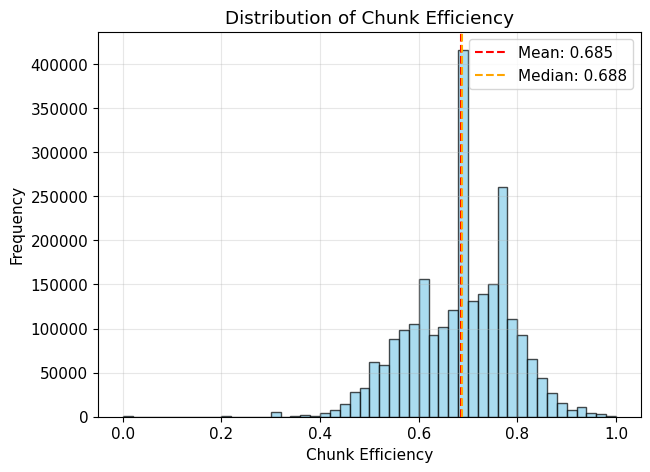

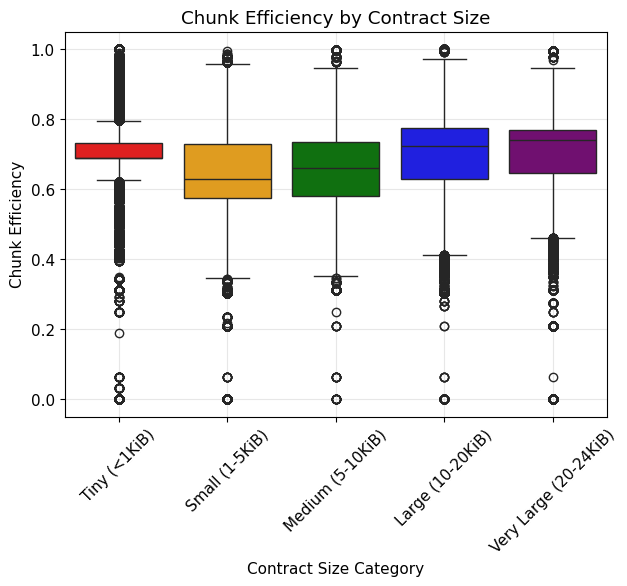

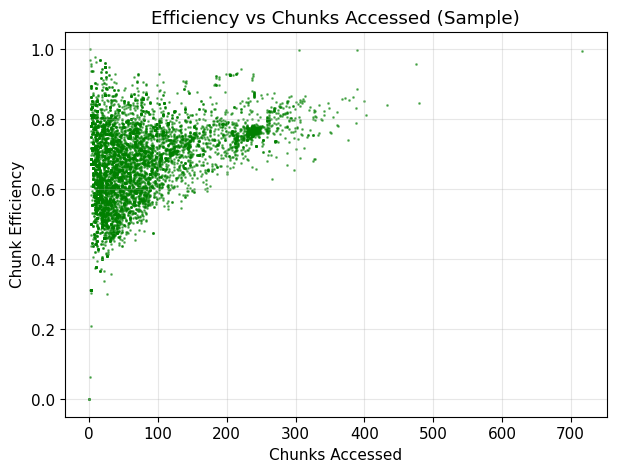

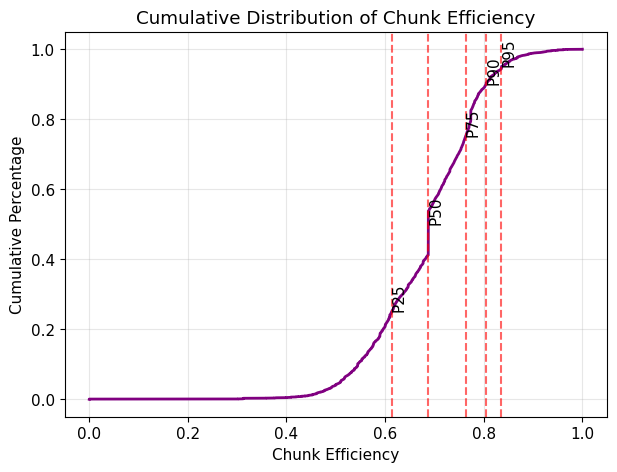

<Figure size 1200x800 with 0 Axes>

Chunk Efficiency Percentiles:
P10: 0.5443
P25: 0.6136
P50: 0.6875
P75: 0.7631
P90: 0.8047
P95: 0.8359
P99: 0.9069
Chunk Efficiency by Size Category:
Size Category: Medium (5-10KiB)
Average: 0.6583
Median: 0.6607

Size Category: Large (10-20KiB)
Average: 0.6982
Median: 0.7230

Size Category: Small (1-5KiB)
Average: 0.6512
Median: 0.6289

Size Category: Tiny (<1KiB)
Average: 0.7145
Median: 0.6875

Size Category: Very Large (20-24KiB)
Average: 0.7079
Median: 0.7388



In [41]:
# 1. Efficiency distribution histogram
plt.figure(figsize=(7, 5))
plt.hist(df_clean['chunk_efficiency'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(df_clean['chunk_efficiency'].mean(), color='red', linestyle='--', label=f'Mean: {df_clean["chunk_efficiency"].mean():.3f}')
plt.axvline(df_clean['chunk_efficiency'].median(), color='orange', linestyle='--', label=f'Median: {df_clean["chunk_efficiency"].median():.3f}')
plt.xlabel('Chunk Efficiency')
plt.ylabel('Frequency')
plt.title('Distribution of Chunk Efficiency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Efficiency by contract size
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_clean, x='size_category', y='chunk_efficiency', palette=['red', 'orange', 'green', 'blue', 'purple', 'brown'])
plt.title('Chunk Efficiency by Contract Size')
plt.xlabel('Contract Size Category')
plt.ylabel('Chunk Efficiency')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

# 3. Efficiency vs chunks accessed (scatter plot with sample)
plt.figure(figsize=(7, 5))
sample_data = df_clean.sample(n=min(10000, len(df_clean)), random_state=42)
plt.scatter(sample_data['chunks_count'], sample_data['chunk_efficiency'], 
           alpha=0.5, s=1, color='green')
plt.xlabel('Chunks Accessed')
plt.ylabel('Chunk Efficiency')
plt.title('Efficiency vs Chunks Accessed (Sample)')
plt.grid(True, alpha=0.3)
plt.show()

# 4. Cumulative efficiency distribution
plt.figure(figsize=(7, 5))
sorted_efficiency = np.sort(df_clean['chunk_efficiency'])
cumulative_pct = np.arange(1, len(sorted_efficiency) + 1) / len(sorted_efficiency)
plt.plot(sorted_efficiency, cumulative_pct, color='purple', linewidth=2)
plt.xlabel('Chunk Efficiency')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Distribution of Chunk Efficiency')
plt.grid(True, alpha=0.3)

# Add key percentiles
percentiles = [25, 50, 75, 90, 95]
for p in percentiles:
    val = np.percentile(df_clean['chunk_efficiency'], p)
    plt.axvline(val, color='red', linestyle='--', alpha=0.6)
    plt.text(val, p/100, f'P{p}', rotation=90, verticalalignment='bottom')
plt.show()

plt.tight_layout()
plt.show()

# Print key percentiles
print("Chunk Efficiency Percentiles:")
for p in [10, 25, 50, 75, 90, 95, 99]:
    val = np.percentile(df_clean['chunk_efficiency'], p)
    print(f"P{p}: {val:.4f}")

# Print the average and median of the chunk efficiency for each size category
print("Chunk Efficiency by Size Category:")
for size_category in df_clean['size_category'].unique():
    size_data = df_clean[df_clean['size_category'] == size_category]
    print(f"Size Category: {size_category}")
    print(f"Average: {size_data['chunk_efficiency'].mean():.4f}")
    print(f"Median: {size_data['chunk_efficiency'].median():.4f}")
    print()


## 4. Feature Engineering - Calculate Key Metrics

In [30]:
# Calculate derived metrics (building on existing chunk efficiency analysis)
# df_analysis = df_clean.copy()
df_analysis = df_clean

# Calculate total chunks (bytecode_size / 32)
df_analysis['total_chunks'] = np.ceil(df_analysis['bytecode_size'] / 32).astype(int)

# Calculate proportions (main research questions)
df_analysis['bytes_accessed_ratio'] = df_analysis['bytes_count'] / df_analysis['bytecode_size']
df_analysis['chunks_accessed_ratio'] = df_analysis['chunks_count'] / df_analysis['total_chunks']

# Additional metrics for deeper analysis
# Handle division by zero for avg_bytes_per_chunk
df_analysis['avg_bytes_per_chunk'] = np.where(
    df_analysis['chunks_count'] > 0,
    df_analysis['bytes_count'] / df_analysis['chunks_count'],
    0
)

# Handle division by zero for code_ops_per_byte
df_analysis['code_ops_per_byte'] = np.where(
    df_analysis['bytecode_size'] > 0,
    df_analysis['code_ops_count'] / df_analysis['bytecode_size'],
    0
)

# Enhanced contract size categories (updated for better analysis)
size_category_labels = ['Tiny (<1KiB)', 'Small (1-5KiB)', 'Medium (5-10KiB)', 
                        'Large (10-20KiB)', 'Very Large (20-24KiB)']
# df_analysis['size_category_detailed'] = pd.cut(df_analysis['bytecode_size'], 
#                                              bins=[0, 1023, 5119, 10239, 20479, float('inf')],
#                                              labels=size_category_labels)

print("Calculated metrics (including chunk efficiency):")
metrics_cols = ['bytes_accessed_ratio', 'chunks_accessed_ratio', 'chunk_efficiency', 
               'total_chunks', 'avg_bytes_per_chunk']
print(df_analysis[metrics_cols].describe())

print(f"\nDetailed contract size distribution:")
print(df_analysis['size_category_detailed'].value_counts().sort_index())

print(f"\nCode operations analysis:")
print(f"Contracts with code size/hash operations: {(df_analysis['code_size_hash_count'] > 0).sum():,}")
print(f"Contracts with code copy operations: {(df_analysis['code_copy_count'] > 0).sum():,}")
print(f"Contracts with any code operations: {(df_analysis['code_ops_count'] > 0).sum():,}")
print(f"Mean code operations per contract: {df_analysis['code_ops_count'].mean():.2f}")

Calculated metrics (including chunk efficiency):
       bytes_accessed_ratio  chunks_accessed_ratio  chunk_efficiency  \
count          2.460321e+06           2.460321e+06      2.460321e+06   
mean           3.000115e-01           3.681864e-01      6.848192e-01   
std            2.959514e-01           2.938890e-01      1.024427e-01   
min            0.000000e+00           0.000000e+00      0.000000e+00   
25%            1.017159e-01           1.666667e-01      6.136364e-01   
50%            1.927932e-01           2.727273e-01      6.875000e-01   
75%            3.320520e-01           4.615385e-01      7.630682e-01   
max            1.000000e+00           1.000000e+00      1.000000e+00   

       total_chunks  avg_bytes_per_chunk  
count  2.460321e+06         2.460321e+06  
mean   2.744969e+02         2.191421e+01  
std    2.515054e+02         3.278165e+00  
min    1.000000e+00         0.000000e+00  
25%    5.200000e+01         1.963636e+01  
50%    2.080000e+02         2.200000e+01  
7

## 5. Comprehensive Analysis Summary

In [31]:
# Comprehensive analysis combining all insights
print("=" * 80)
print("COMPREHENSIVE ETHEREUM CODE CHUNKING ANALYSIS SUMMARY")
print("=" * 80)
print()

# Dataset overview
print("📊 DATASET OVERVIEW")
print(f"Total contract executions analyzed: {len(df_analysis):,}")
print(f"Unique contracts: {df_analysis['address'].nunique():,}")
print(f"Block range: {df_analysis['block_number'].min():,} - {df_analysis['block_number'].max():,}")
print(f"Average executions per contract: {len(df_analysis) / df_analysis['address'].nunique():.1f}")
print()

# Key findings
print("🔍 KEY FINDINGS")
print()

print("1. CHUNK EFFICIENCY")
mean_eff = df_analysis['chunk_efficiency'].mean()
median_eff = df_analysis['chunk_efficiency'].median()
perfect_eff = (df_analysis['chunk_efficiency'] == 1.0).mean() * 100

print(f"   • Average chunk efficiency: {mean_eff:.1%}")
print(f"   • Median chunk efficiency: {median_eff:.1%}")
print(f"   • Contracts with perfect efficiency: {perfect_eff:.1f}%")

# Efficiency by size
print(f"\n   Efficiency by contract size:")
size_eff = df_analysis.groupby('size_category')['chunk_efficiency'].mean()
for size, eff in size_eff.items():
    count = (df_analysis['size_category'] == size).sum()
    print(f"   • {size}: {eff:.1%} (n={count:,})")

print()

print("2. CODE ACCESS PATTERNS")
mean_bytes_ratio = df_analysis['bytes_accessed_ratio'].mean()
mean_chunks_ratio = df_analysis['chunks_accessed_ratio'].mean()

print(f"   • Average bytes accessed: {mean_bytes_ratio:.1%} of total bytecode")
print(f"   • Average chunks accessed: {mean_chunks_ratio:.1%} of total chunks")

# Zero access analysis
zero_access = (df_analysis['chunks_count'] == 0).mean() * 100
print(f"   • Contracts with no code access: {zero_access:.1f}%")

print()

print("3. CODE OPERATIONS")
has_size_hash = (df_analysis['code_size_hash_count'] > 0).mean() * 100
has_copy = (df_analysis['code_copy_count'] > 0).mean() * 100
has_any_ops = (df_analysis['code_ops_count'] > 0).mean() * 100

print(f"   • Contracts with size/hash operations: {has_size_hash:.1f}%")
print(f"   • Contracts with copy operations: {has_copy:.1f}%")
print(f"   • Contracts with any code operations: {has_any_ops:.1f}%")

print()

print("4. EFFICIENCY INSIGHTS")
total_wasted = df_analysis['wasted_bytes'].sum()
total_potential = df_analysis['potential_bytes'].sum()
waste_pct = (total_wasted / total_potential) * 100 if total_potential > 0 else 0

print(f"   • Total bytes wasted due to chunking: {total_wasted:,}")
print(f"   • Percentage of accessed chunk space wasted: {waste_pct:.1f}%")

# High efficiency contracts
high_eff = (df_analysis['chunk_efficiency'] > 0.9).mean() * 100
low_eff = (df_analysis['chunk_efficiency'] < 0.1).mean() * 100

print(f"   • Contracts with high efficiency (>90%): {high_eff:.1f}%")
print(f"   • Contracts with low efficiency (<10%): {low_eff:.1f}%")

print()

print("💡 IMPLICATIONS")
print("   • 32-byte chunking leads to significant byte waste in accessed chunks")
print("   • Smaller contracts tend to have higher chunk efficiency")
print("   • Many contracts access only a small portion of their bytecode")
print("   • Chunk-based loading could benefit from variable chunk sizes")

print("\n" + "=" * 80)


COMPREHENSIVE ETHEREUM CODE CHUNKING ANALYSIS SUMMARY

📊 DATASET OVERVIEW
Total contract executions analyzed: 2,460,321
Unique contracts: 324,127
Block range: 22,000,000 - 22,010,000
Average executions per contract: 7.6

🔍 KEY FINDINGS

1. CHUNK EFFICIENCY
   • Average chunk efficiency: 68.5%
   • Median chunk efficiency: 68.8%
   • Contracts with perfect efficiency: 0.0%

   Efficiency by contract size:
   • Tiny (<1KiB): 71.5% (n=493,872)
   • Small (1-5KiB): 65.1% (n=622,277)
   • Medium (5-10KiB): 65.8% (n=389,900)
   • Large (10-20KiB): 69.8% (n=556,996)
   • Very Large (20-24KiB): 70.8% (n=397,276)

2. CODE ACCESS PATTERNS
   • Average bytes accessed: 30.0% of total bytecode
   • Average chunks accessed: 36.8% of total chunks
   • Contracts with no code access: 0.0%

3. CODE OPERATIONS
   • Contracts with size/hash operations: 30.9%
   • Contracts with copy operations: 10.4%
   • Contracts with any code operations: 37.1%

4. EFFICIENCY INSIGHTS
   • Total bytes wasted due to chun

## 4. Primary Research Questions Analysis

### Question 1: What is the proportion of bytes accessed over bytecode size?

Bytes Accessed Ratio Statistics:
count    2.460321e+06
mean     3.000115e-01
std      2.959514e-01
min      0.000000e+00
25%      1.017159e-01
50%      1.927932e-01
75%      3.320520e-01
max      1.000000e+00
Name: bytes_accessed_ratio, dtype: float64


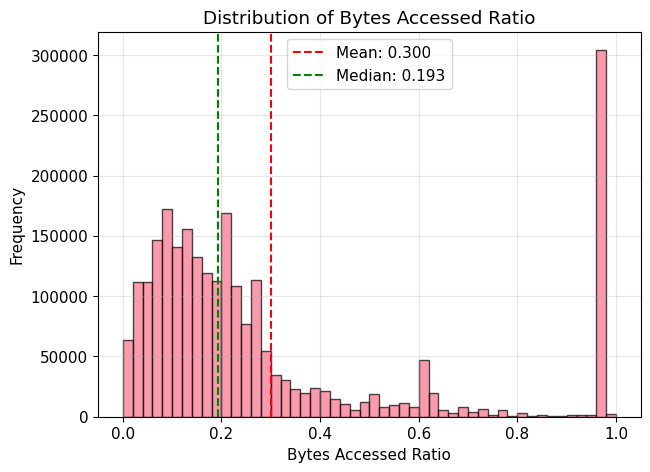

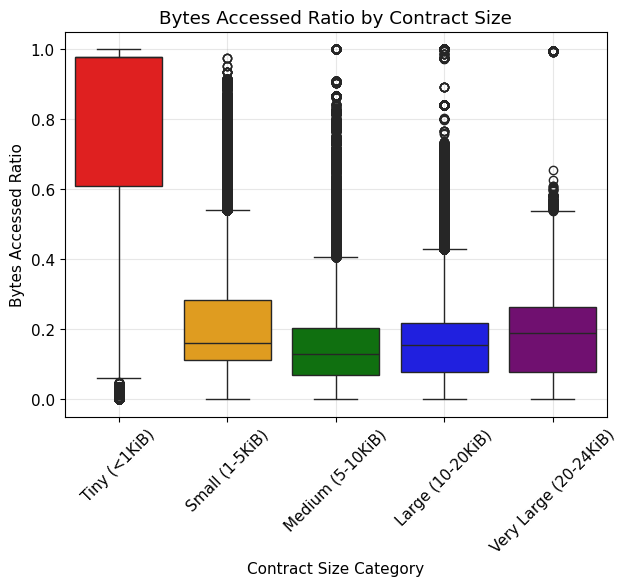

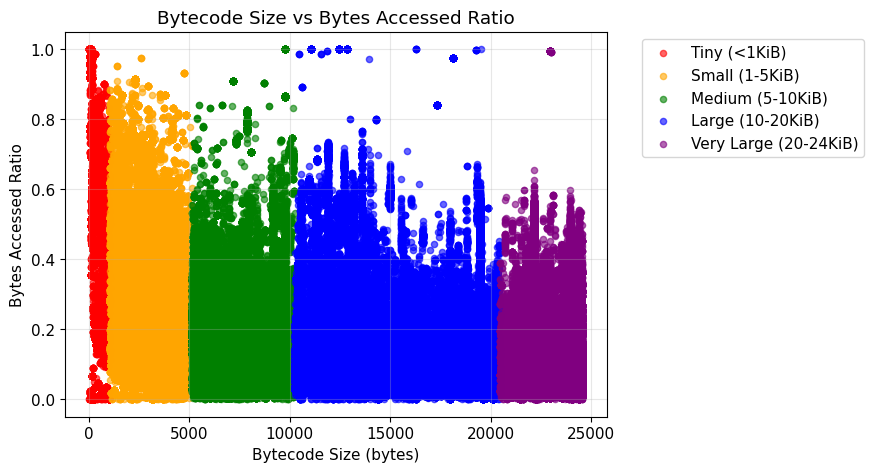

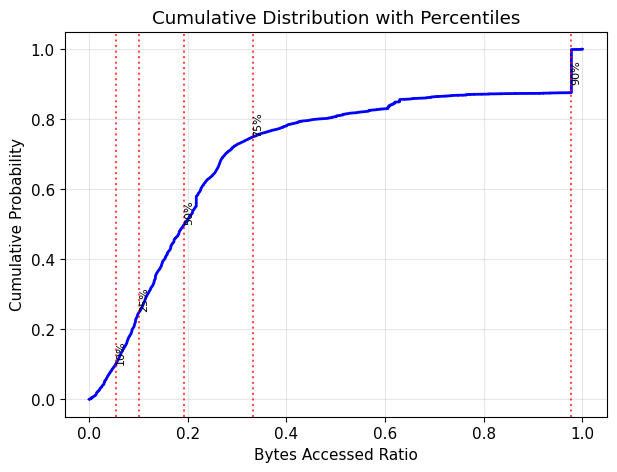


KEY INSIGHTS - Bytes Accessed Ratio:
• Average proportion of bytes accessed: 30.0%
• Median proportion of bytes accessed: 19.3%
• 10th percentile: 5.4%
• 90th percentile: 97.8%
• Contracts with >50% bytes accessed: 474,225 (19.3%)

📊 By Contract Size:
• Tiny (<1KiB): 493,872 contracts, avg 77.9%, median 97.8%
• Small (1-5KiB): 622,277 contracts, avg 21.7%, median 15.9%
• Medium (5-10KiB): 389,900 contracts, avg 15.0%, median 12.7%
• Large (10-20KiB): 556,996 contracts, avg 16.3%, median 15.6%
• Very Large (20-24KiB): 397,276 contracts, avg 17.4%, median 18.8%


In [38]:
# Analysis of bytes accessed ratio
bytes_ratio_stats = df_analysis['bytes_accessed_ratio'].describe()
print("Bytes Accessed Ratio Statistics:")
print(bytes_ratio_stats)

# Create visualization
# 1. Histogram
plt.figure(figsize=(7, 5))
plt.hist(df_analysis['bytes_accessed_ratio'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(bytes_ratio_stats['mean'], color='red', linestyle='--', label=f'Mean: {bytes_ratio_stats["mean"]:.3f}')
plt.axvline(bytes_ratio_stats['50%'], color='green', linestyle='--', label=f'Median: {bytes_ratio_stats["50%"]:.3f}')
plt.xlabel('Bytes Accessed Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Bytes Accessed Ratio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Box plot by contract size
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_analysis, x='size_category', y='bytes_accessed_ratio', 
            palette=['red', 'orange', 'green', 'blue', 'purple'])
plt.title('Bytes Accessed Ratio by Contract Size')
plt.xlabel('Contract Size Category')
plt.ylabel('Bytes Accessed Ratio')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

# 3. Scatter plot
plt.figure(figsize=(7, 5))
size_colors = {size_category_labels[0]: 'red', size_category_labels[1]: 'orange', size_category_labels[2]: 'green', 
               size_category_labels[3]: 'blue', size_category_labels[4]: 'purple'}
for size_cat, color in size_colors.items():
    mask = df_analysis['size_category'] == size_cat
    if mask.any():
        plt.scatter(df_analysis[mask]['bytecode_size'], 
                    df_analysis[mask]['bytes_accessed_ratio'], 
                    alpha=0.6, label=size_cat, color=color, s=20)
plt.xlabel('Bytecode Size (bytes)')
plt.ylabel('Bytes Accessed Ratio')
plt.title('Bytecode Size vs Bytes Accessed Ratio')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# 4. Cumulative distribution
plt.figure(figsize=(7, 5))
sorted_ratios = np.sort(df_analysis['bytes_accessed_ratio'])
y_values = np.arange(1, len(sorted_ratios) + 1) / len(sorted_ratios)
plt.plot(sorted_ratios, y_values, linewidth=2, color='blue')
percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
    val = np.percentile(df_analysis['bytes_accessed_ratio'], p)
    plt.axvline(val, color='red', linestyle=':', alpha=0.7)
    plt.text(val, p/100, f'{p}%', rotation=90, verticalalignment='bottom', fontsize=8)
plt.xlabel('Bytes Accessed Ratio')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution with Percentiles')
plt.grid(True, alpha=0.3)
plt.show()

# Enhanced insights with contract size breakdown
print(f"\nKEY INSIGHTS - Bytes Accessed Ratio:")
print(f"• Average proportion of bytes accessed: {bytes_ratio_stats['mean']:.1%}")
print(f"• Median proportion of bytes accessed: {bytes_ratio_stats['50%']:.1%}")
print(f"• 10th percentile: {np.percentile(df_analysis['bytes_accessed_ratio'], 10):.1%}")
print(f"• 90th percentile: {np.percentile(df_analysis['bytes_accessed_ratio'], 90):.1%}")
print(f"• Contracts with >50% bytes accessed: {(df_analysis['bytes_accessed_ratio'] > 0.5).sum():,} ({(df_analysis['bytes_accessed_ratio'] > 0.5).mean():.1%})")

# Size-specific insights
print(f"\n📊 By Contract Size:")
size_summary = df_analysis.groupby('size_category')['bytes_accessed_ratio'].agg(['count', 'mean', 'median']).round(3)
for size_cat in size_category_labels:
    if size_cat in size_summary.index:
        count = size_summary.loc[size_cat, 'count']
        mean_ratio = size_summary.loc[size_cat, 'mean']
        median_ratio = size_summary.loc[size_cat, 'median']
        print(f"• {size_cat}: {count:,} contracts, avg {mean_ratio:.1%}, median {median_ratio:.1%}")

### Question 2: What is the proportion of chunks accessed over total chunks?

Chunks Accessed Ratio Statistics:
count    2.460321e+06
mean     3.681864e-01
std      2.938890e-01
min      0.000000e+00
25%      1.666667e-01
50%      2.727273e-01
75%      4.615385e-01
max      1.000000e+00
Name: chunks_accessed_ratio, dtype: float64


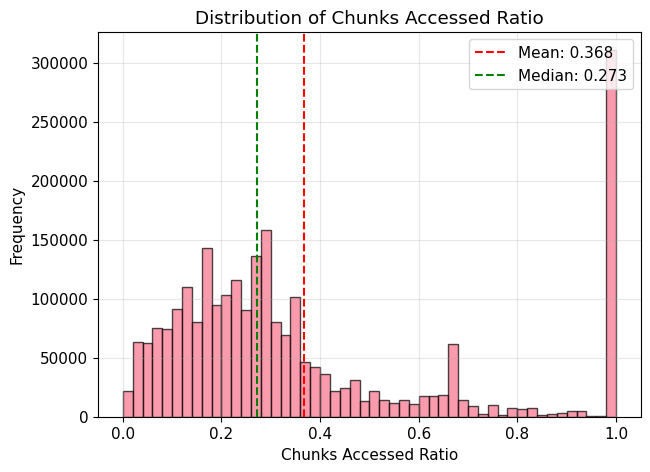

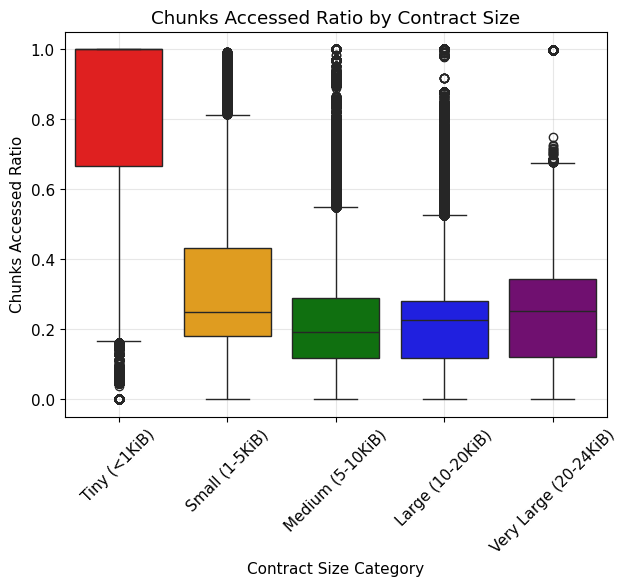

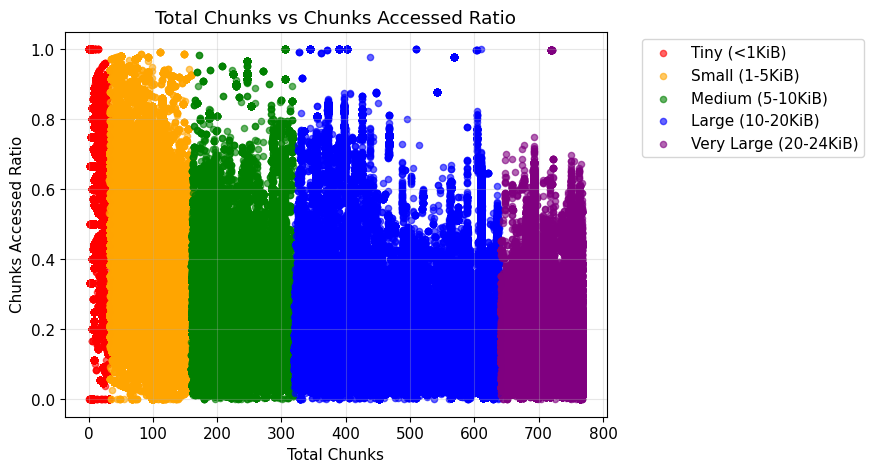

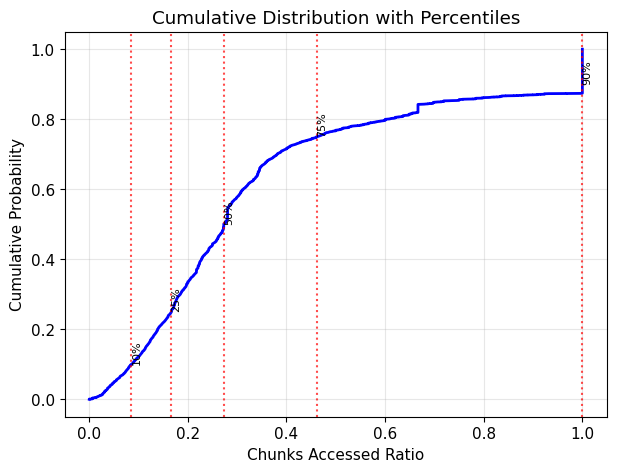


KEY INSIGHTS - Chunks Accessed Ratio:
• Average proportion of chunks accessed: 36.8%
• Median proportion of chunks accessed: 27.3%
• 10th percentile: 8.6%
• 90th percentile: 100.0%
• Contracts with >50% chunks accessed: 569,026 (23.1%)

📊 By Contract Size:
• Tiny (<1KiB): 493,872 contracts, avg 82.4%, median 100.0%
• Small (1-5KiB): 622,277 contracts, avg 31.7%, median 25.0%
• Medium (5-10KiB): 389,900 contracts, avg 21.9%, median 19.2%
• Large (10-20KiB): 556,996 contracts, avg 22.3%, median 22.5%
• Very Large (20-24KiB): 397,276 contracts, avg 23.3%, median 25.1%


In [39]:
# Analysis of chunks accessed ratio
chunks_ratio_stats = df_analysis['chunks_accessed_ratio'].describe()
print("Chunks Accessed Ratio Statistics:")
print(chunks_ratio_stats)

# 1. Histogram
plt.figure(figsize=(7, 5))
plt.hist(df_analysis['chunks_accessed_ratio'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(chunks_ratio_stats['mean'], color='red', linestyle='--', label=f'Mean: {chunks_ratio_stats["mean"]:.3f}')
plt.axvline(chunks_ratio_stats['50%'], color='green', linestyle='--', label=f'Median: {chunks_ratio_stats["50%"]:.3f}')
plt.xlabel('Chunks Accessed Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Chunks Accessed Ratio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Colored box plot by contract size using seaborn
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_analysis, x='size_category', y='chunks_accessed_ratio', 
            palette=['red', 'orange', 'green', 'blue', 'purple'])
plt.title('Chunks Accessed Ratio by Contract Size')
plt.xlabel('Contract Size Category')
plt.ylabel('Chunks Accessed Ratio')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

# 3. Scatter plot with color coding by size
plt.figure(figsize=(7, 5))
size_colors = {size_category_labels[0]: 'red', size_category_labels[1]: 'orange', size_category_labels[2]: 'green', 
               size_category_labels[3]: 'blue', size_category_labels[4]: 'purple'}
for size_cat, color in size_colors.items():
    mask = df_analysis['size_category'] == size_cat
    if mask.any():
        plt.scatter(df_analysis[mask]['total_chunks'], 
                    df_analysis[mask]['chunks_accessed_ratio'], 
                    alpha=0.6, label=size_cat, color=color, s=20)
plt.xlabel('Total Chunks')
plt.ylabel('Chunks Accessed Ratio')
plt.title('Total Chunks vs Chunks Accessed Ratio')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# 4. Cumulative distribution with percentile markers
plt.figure(figsize=(7, 5))
sorted_chunk_ratios = np.sort(df_analysis['chunks_accessed_ratio'])
y_values = np.arange(1, len(sorted_chunk_ratios) + 1) / len(sorted_chunk_ratios)
plt.plot(sorted_chunk_ratios, y_values, linewidth=2, color='blue')
percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
    val = np.percentile(df_analysis['chunks_accessed_ratio'], p)
    plt.axvline(val, color='red', linestyle=':', alpha=0.7)
    plt.text(val, p/100, f'{p}%', rotation=90, verticalalignment='bottom', fontsize=8)
plt.xlabel('Chunks Accessed Ratio')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution with Percentiles')
plt.grid(True, alpha=0.3)
plt.show()

# Enhanced insights with contract size breakdown
print(f"\nKEY INSIGHTS - Chunks Accessed Ratio:")
print(f"• Average proportion of chunks accessed: {chunks_ratio_stats['mean']:.1%}")
print(f"• Median proportion of chunks accessed: {chunks_ratio_stats['50%']:.1%}")
print(f"• 10th percentile: {np.percentile(df_analysis['chunks_accessed_ratio'], 10):.1%}")
print(f"• 90th percentile: {np.percentile(df_analysis['chunks_accessed_ratio'], 90):.1%}")
print(f"• Contracts with >50% chunks accessed: {(df_analysis['chunks_accessed_ratio'] > 0.5).sum():,} ({(df_analysis['chunks_accessed_ratio'] > 0.5).mean():.1%})")

# Size-specific insights
print(f"\n📊 By Contract Size:")
size_summary = df_analysis.groupby('size_category')['chunks_accessed_ratio'].agg(['count', 'mean', 'median']).round(3)
for size_cat in size_category_labels:
    if size_cat in size_summary.index:
        count = size_summary.loc[size_cat, 'count']
        mean_ratio = size_summary.loc[size_cat, 'mean']
        median_ratio = size_summary.loc[size_cat, 'median']
        print(f"• {size_cat}: {count:,} contracts, avg {mean_ratio:.1%}, median {median_ratio:.1%}")

### Question 3: How do code operations affect access patterns?

QUESTION 3: Impact of Code Operations on Access Patterns
Note: Each code operation accesses the ENTIRE bytecode (all chunks)

COMPARISON: Original vs Code-Operations-Adjusted Access Ratios
------------------------------------------------------------
BYTES ACCESS RATIOS:
• Original average: 30.0%
• Adjusted average (considering code ops): 59.0%
• Increase due to code ops: 29.0%

CHUNKS ACCESS RATIOS:
• Original average: 36.8%
• Adjusted average (considering code ops): 63.0%
• Increase due to code ops: 26.2%

IMPACT BY CONTRACT SIZE CATEGORY:
----------------------------------------
Tiny (<1KiB):
  • 15.3% have code operations
  • Bytes ratio: 77.9% → 84.8% (+6.9%)
  • Chunks ratio: 82.4% → 88.1% (+5.7%)
Small (1-5KiB):
  • 39.0% have code operations
  • Bytes ratio: 21.7% → 51.5% (+29.8%)
  • Chunks ratio: 31.7% → 57.6% (+25.9%)
Medium (5-10KiB):
  • 41.4% have code operations
  • Bytes ratio: 15.0% → 49.5% (+34.5%)
  • Chunks ratio: 21.9% → 53.2% (+31.3%)
Large (10-20KiB):
  • 49.4% ha

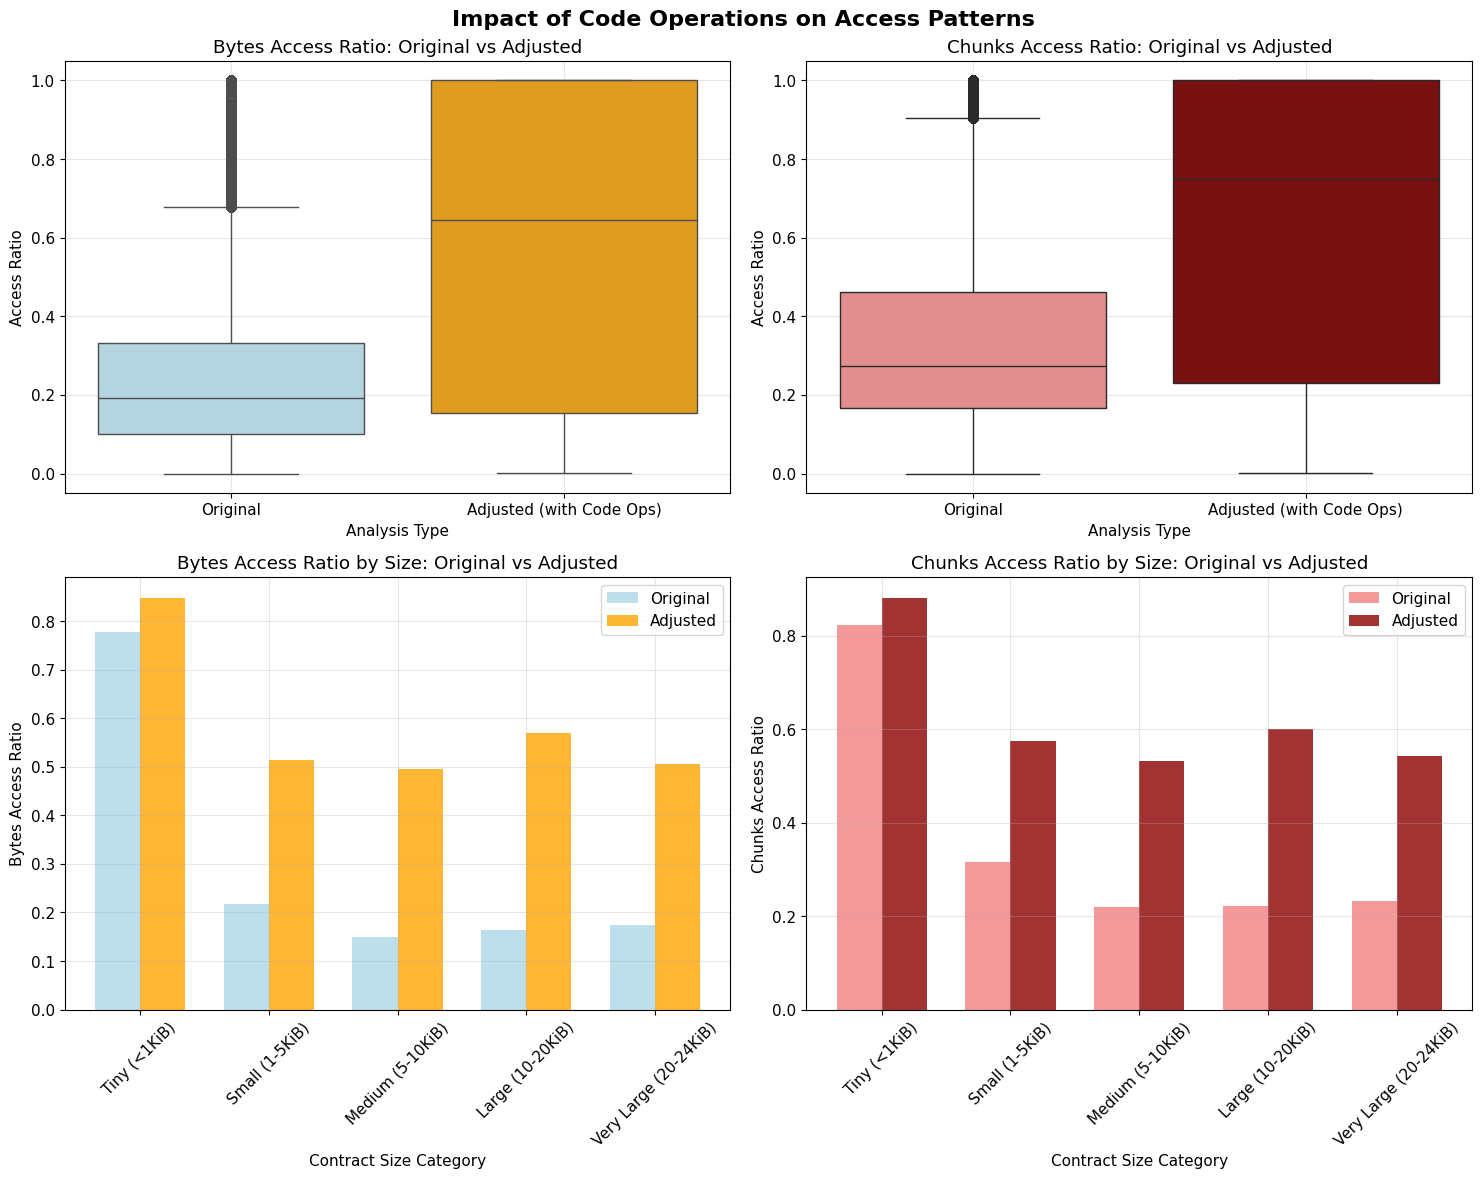


🔍 KEY INSIGHTS - Code Operations Impact:
• Contracts with code operations effectively have 100% access ratios
• 37.1% of contracts have code operations
• Code operations increase average bytes access from 30.0% to 59.0%
• Code operations increase average chunks access from 36.8% to 63.0%
• The impact varies significantly by contract size

EFFICIENCY RECLASSIFICATION (considering code operations):
• High efficiency (>50% access): 1,309,685 contracts (53.2%)
• Medium efficiency (20-50% access): 392,014 contracts (15.9%)
• Low efficiency (<20% access): 758,622 contracts (30.8%)


In [34]:
# Question 3: Impact of Code Operations on Access Patterns
# Each code operation (EXTCODESIZE, EXTCODECOPY, EXTCODEHASH, CODECOPY, CODESIZE) accesses the entire bytecode

print("QUESTION 3: Impact of Code Operations on Access Patterns")
print("="*70)
print("Note: Each code operation accesses the ENTIRE bytecode (all chunks)")
print()

# Calculate adjusted access ratios considering code operations
# If code_ops_count > 0, then effectively ALL bytes and chunks are accessed at least once
df_analysis['adjusted_bytes_ratio'] = df_analysis.apply(
    lambda row: 1.0 if row['code_ops_count'] > 0 else row['bytes_accessed_ratio'], axis=1
)

df_analysis['adjusted_chunks_ratio'] = df_analysis.apply(
    lambda row: 1.0 if row['code_ops_count'] > 0 else row['chunks_accessed_ratio'], axis=1
)

# Compare original vs adjusted ratios
print("COMPARISON: Original vs Code-Operations-Adjusted Access Ratios")
print("-" * 60)

original_bytes_mean = df_analysis['bytes_accessed_ratio'].mean()
adjusted_bytes_mean = df_analysis['adjusted_bytes_ratio'].mean()
original_chunks_mean = df_analysis['chunks_accessed_ratio'].mean()
adjusted_chunks_mean = df_analysis['adjusted_chunks_ratio'].mean()

print(f"BYTES ACCESS RATIOS:")
print(f"• Original average: {original_bytes_mean:.1%}")
print(f"• Adjusted average (considering code ops): {adjusted_bytes_mean:.1%}")
print(f"• Increase due to code ops: {adjusted_bytes_mean - original_bytes_mean:.1%}")

print(f"\nCHUNKS ACCESS RATIOS:")
print(f"• Original average: {original_chunks_mean:.1%}")
print(f"• Adjusted average (considering code ops): {adjusted_chunks_mean:.1%}")
print(f"• Increase due to code ops: {adjusted_chunks_mean - original_chunks_mean:.1%}")

# Analysis by contract size
print(f"\nIMPACT BY CONTRACT SIZE CATEGORY:")
print("-" * 40)

size_comparison = df_analysis.groupby('size_category').agg({
    'bytes_accessed_ratio': 'mean',
    'adjusted_bytes_ratio': 'mean',
    'chunks_accessed_ratio': 'mean', 
    'adjusted_chunks_ratio': 'mean',
    'code_ops_count': ['mean', lambda x: (x > 0).mean()]
}).round(3)

size_comparison.columns = ['Original_Bytes', 'Adjusted_Bytes', 'Original_Chunks', 'Adjusted_Chunks', 'Avg_Code_Ops', 'Pct_With_Code_Ops']

for size_cat in size_category_labels:
    if size_cat in size_comparison.index:
        orig_bytes = size_comparison.loc[size_cat, 'Original_Bytes']
        adj_bytes = size_comparison.loc[size_cat, 'Adjusted_Bytes']
        orig_chunks = size_comparison.loc[size_cat, 'Original_Chunks']
        adj_chunks = size_comparison.loc[size_cat, 'Adjusted_Chunks']
        pct_with_ops = size_comparison.loc[size_cat, 'Pct_With_Code_Ops']
        
        bytes_increase = adj_bytes - orig_bytes
        chunks_increase = adj_chunks - orig_chunks
        
        print(f"{size_cat}:")
        print(f"  • {pct_with_ops:.1%} have code operations")
        print(f"  • Bytes ratio: {orig_bytes:.1%} → {adj_bytes:.1%} (+{bytes_increase:.1%})")
        print(f"  • Chunks ratio: {orig_chunks:.1%} → {adj_chunks:.1%} (+{chunks_increase:.1%})")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Impact of Code Operations on Access Patterns', fontsize=16, fontweight='bold')

# Before vs After comparison - Bytes (colored box plots)
# Create separate datasets for seaborn
bytes_comparison_df = pd.DataFrame({
    'Access_Ratio': list(df_analysis['bytes_accessed_ratio']) + list(df_analysis['adjusted_bytes_ratio']),
    'Type': ['Original'] * len(df_analysis) + ['Adjusted (with Code Ops)'] * len(df_analysis)
})

sns.boxplot(data=bytes_comparison_df, x='Type', y='Access_Ratio', 
            palette=['lightblue', 'orange'], ax=axes[0,0])
axes[0,0].set_title('Bytes Access Ratio: Original vs Adjusted')
axes[0,0].set_xlabel('Analysis Type')
axes[0,0].set_ylabel('Access Ratio')
axes[0,0].grid(True, alpha=0.3)

# Before vs After comparison - Chunks (colored box plots)
chunks_comparison_df = pd.DataFrame({
    'Access_Ratio': list(df_analysis['chunks_accessed_ratio']) + list(df_analysis['adjusted_chunks_ratio']),
    'Type': ['Original'] * len(df_analysis) + ['Adjusted (with Code Ops)'] * len(df_analysis)
})

sns.boxplot(data=chunks_comparison_df, x='Type', y='Access_Ratio', 
            palette=['lightcoral', 'darkred'], ax=axes[0,1])
axes[0,1].set_title('Chunks Access Ratio: Original vs Adjusted')
axes[0,1].set_xlabel('Analysis Type')
axes[0,1].set_ylabel('Access Ratio')
axes[0,1].grid(True, alpha=0.3)

# Impact by contract size - Bytes
size_means_orig = df_analysis.groupby('size_category')['bytes_accessed_ratio'].mean().reindex(size_category_labels)
size_means_adj = df_analysis.groupby('size_category')['adjusted_bytes_ratio'].mean().reindex(size_category_labels)

x_pos = range(len(size_category_labels))
width = 0.35
axes[1,0].bar([x - width/2 for x in x_pos], size_means_orig, width, label='Original', alpha=0.8, color='lightblue')
axes[1,0].bar([x + width/2 for x in x_pos], size_means_adj, width, label='Adjusted', alpha=0.8, color='orange')
axes[1,0].set_xlabel('Contract Size Category')
axes[1,0].set_ylabel('Bytes Access Ratio')
axes[1,0].set_title('Bytes Access Ratio by Size: Original vs Adjusted')
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels(size_category_labels, rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Impact by contract size - Chunks
size_means_orig_chunks = df_analysis.groupby('size_category')['chunks_accessed_ratio'].mean().reindex(size_category_labels)
size_means_adj_chunks = df_analysis.groupby('size_category')['adjusted_chunks_ratio'].mean().reindex(size_category_labels)

axes[1,1].bar([x - width/2 for x in x_pos], size_means_orig_chunks, width, label='Original', alpha=0.8, color='lightcoral')
axes[1,1].bar([x + width/2 for x in x_pos], size_means_adj_chunks, width, label='Adjusted', alpha=0.8, color='darkred')
axes[1,1].set_xlabel('Contract Size Category')
axes[1,1].set_ylabel('Chunks Access Ratio')
axes[1,1].set_title('Chunks Access Ratio by Size: Original vs Adjusted')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(size_category_labels, rotation=45)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
print(f"\n🔍 KEY INSIGHTS - Code Operations Impact:")
print(f"• Contracts with code operations effectively have 100% access ratios")
print(f"• {(df_analysis['code_ops_count'] > 0).mean():.1%} of contracts have code operations")
print(f"• Code operations increase average bytes access from {original_bytes_mean:.1%} to {adjusted_bytes_mean:.1%}")
print(f"• Code operations increase average chunks access from {original_chunks_mean:.1%} to {adjusted_chunks_mean:.1%}")
print(f"• The impact varies significantly by contract size")

# Efficiency reclassification
high_eff_adj = (df_analysis['adjusted_bytes_ratio'] > 0.5) & (df_analysis['adjusted_chunks_ratio'] > 0.5)
medium_eff_adj = ((df_analysis['adjusted_bytes_ratio'] > 0.2) & (df_analysis['adjusted_chunks_ratio'] > 0.2)) & ~high_eff_adj
low_eff_adj = ~high_eff_adj & ~medium_eff_adj

print(f"\nEFFICIENCY RECLASSIFICATION (considering code operations):")
print(f"• High efficiency (>50% access): {high_eff_adj.sum():,} contracts ({high_eff_adj.mean():.1%})")
print(f"• Medium efficiency (20-50% access): {medium_eff_adj.sum():,} contracts ({medium_eff_adj.mean():.1%})")
print(f"• Low efficiency (<20% access): {low_eff_adj.sum():,} contracts ({low_eff_adj.mean():.1%})")

QUESTION 3a: Impact of Code Size Hash Operations on Access Patterns
Note: Each code size hash operation accesses the ENTIRE bytecode (all chunks)

COMPARISON: Original vs Code-Operations-Adjusted Access Ratios
------------------------------------------------------------
BYTES ACCESS RATIOS:
• Original average: 30.0%
• Adjusted average (considering code size hash ops): 53.7%
• Increase due to code ops: 23.7%

CHUNKS ACCESS RATIOS:
• Original average: 36.8%
• Adjusted average (considering code size hash ops): 58.2%
• Increase due to code ops: 21.4%

IMPACT BY CONTRACT SIZE CATEGORY:
----------------------------------------
Tiny (<1KiB):
  • 14.9% have code operations
  • Bytes ratio: 77.9% → 84.5% (+6.6%)
  • Chunks ratio: 82.4% → 88.0% (+5.6%)
Small (1-5KiB):
  • 34.5% have code operations
  • Bytes ratio: 21.7% → 48.0% (+26.3%)
  • Chunks ratio: 31.7% → 54.5% (+22.8%)
Medium (5-10KiB):
  • 31.3% have code operations
  • Bytes ratio: 15.0% → 40.8% (+25.8%)
  • Chunks ratio: 21.9% → 45.2

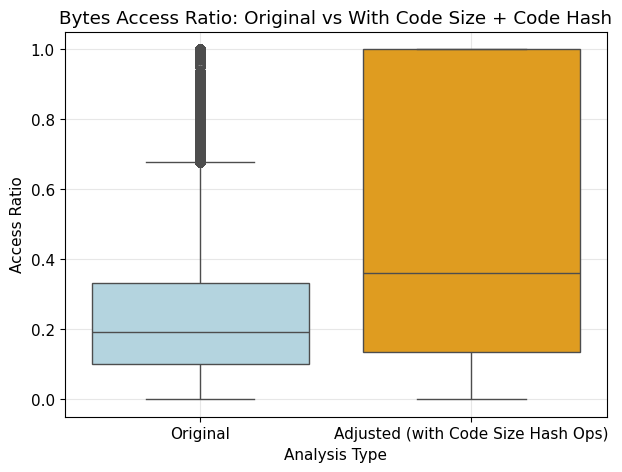

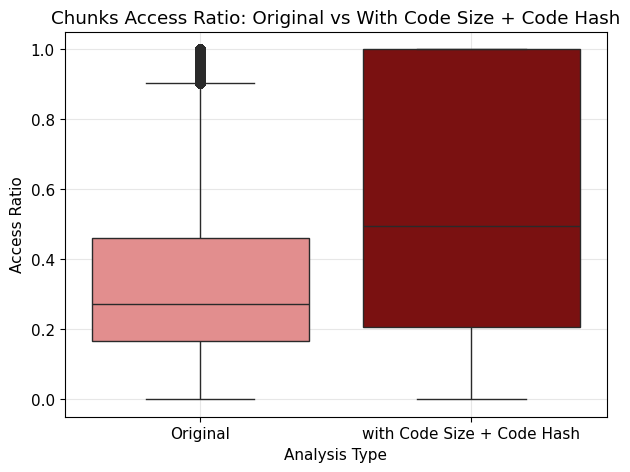

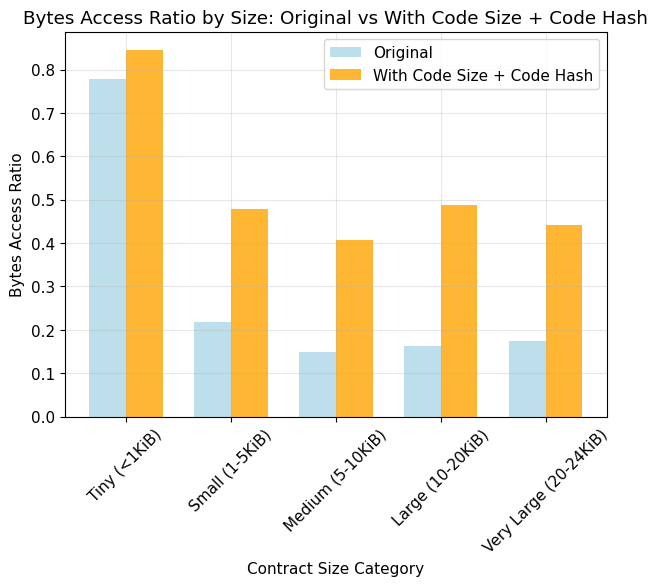

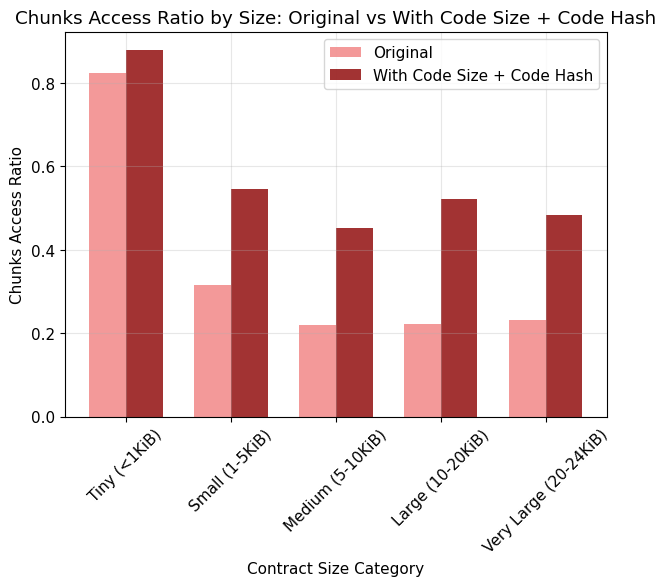


🔍 KEY INSIGHTS - Code Size Hash Operations Impact:
• Contracts with code size hash operations effectively have 100% access ratios
• 30.9% of contracts have code size hash operations
• Code size hash operations increase average bytes access from 30.0% to 53.7%
• Code size hash operations increase average chunks access from 36.8% to 58.2%
• The impact varies significantly by contract size

EFFICIENCY RECLASSIFICATION (considering code size hash operations):
• High efficiency (>50% access): 1,159,838 contracts (47.1%)
• Medium efficiency (20-50% access): 423,580 contracts (17.2%)
• Low efficiency (<20% access): 876,903 contracts (35.6%)


In [45]:
# Question 3a: Impact of Code Size Hash Operations on Access Patterns
# Each code operation (EXTCODESIZE, EXTCODECOPY, EXTCODEHASH, CODECOPY, CODESIZE) accesses the entire bytecode

print("QUESTION 3a: Impact of Code Size Hash Operations on Access Patterns")
print("="*70)
print("Note: Each code size hash operation accesses the ENTIRE bytecode (all chunks)")
print()

# Calculate adjusted access ratios considering code size hash operations
# If code_size_hash_count > 0, then effectively ALL bytes and chunks are accessed at least once
df_analysis['adjusted_csh_bytes_ratio'] = df_analysis.apply(
    lambda row: 1.0 if row['code_size_hash_count'] > 0 else row['bytes_accessed_ratio'], axis=1
)

df_analysis['adjusted_csh_chunks_ratio'] = df_analysis.apply(
    lambda row: 1.0 if row['code_size_hash_count'] > 0 else row['chunks_accessed_ratio'], axis=1
)

# Compare original vs adjusted ratios
print("COMPARISON: Original vs Code-Operations-Adjusted Access Ratios")
print("-" * 60)

original_bytes_mean = df_analysis['bytes_accessed_ratio'].mean()
adjusted_bytes_mean = df_analysis['adjusted_csh_bytes_ratio'].mean()
original_chunks_mean = df_analysis['chunks_accessed_ratio'].mean()
adjusted_chunks_mean = df_analysis['adjusted_csh_chunks_ratio'].mean()

print(f"BYTES ACCESS RATIOS:")
print(f"• Original average: {original_bytes_mean:.1%}")
print(f"• Adjusted average (considering code size hash ops): {adjusted_bytes_mean:.1%}")
print(f"• Increase due to code ops: {adjusted_bytes_mean - original_bytes_mean:.1%}")

print(f"\nCHUNKS ACCESS RATIOS:")
print(f"• Original average: {original_chunks_mean:.1%}")
print(f"• Adjusted average (considering code size hash ops): {adjusted_chunks_mean:.1%}")
print(f"• Increase due to code ops: {adjusted_chunks_mean - original_chunks_mean:.1%}")

# Analysis by contract size
print(f"\nIMPACT BY CONTRACT SIZE CATEGORY:")
print("-" * 40)

size_comparison = df_analysis.groupby('size_category').agg({
    'bytes_accessed_ratio': 'mean',
    'adjusted_csh_bytes_ratio': 'mean',
    'chunks_accessed_ratio': 'mean', 
    'adjusted_csh_chunks_ratio': 'mean',
    'code_size_hash_count': ['mean', lambda x: (x > 0).mean()]
}).round(3)

size_comparison.columns = ['Original_Bytes', 'Adjusted_Bytes', 'Original_Chunks', 'Adjusted_Chunks', 'Avg_Code_Ops', 'Pct_With_Code_Ops']

for size_cat in size_category_labels:
    if size_cat in size_comparison.index:
        orig_bytes = size_comparison.loc[size_cat, 'Original_Bytes']
        adj_bytes = size_comparison.loc[size_cat, 'Adjusted_Bytes']
        orig_chunks = size_comparison.loc[size_cat, 'Original_Chunks']
        adj_chunks = size_comparison.loc[size_cat, 'Adjusted_Chunks']
        pct_with_ops = size_comparison.loc[size_cat, 'Pct_With_Code_Ops']
        
        bytes_increase = adj_bytes - orig_bytes
        chunks_increase = adj_chunks - orig_chunks
        
        print(f"{size_cat}:")
        print(f"  • {pct_with_ops:.1%} have code operations")
        print(f"  • Bytes ratio: {orig_bytes:.1%} → {adj_bytes:.1%} (+{bytes_increase:.1%})")
        print(f"  • Chunks ratio: {orig_chunks:.1%} → {adj_chunks:.1%} (+{chunks_increase:.1%})")

# Visualization
# 1. Before vs After comparison - Bytes (colored box plots)
plt.figure(figsize=(7, 5))
bytes_comparison_df = pd.DataFrame({
    'Access_Ratio': list(df_analysis['bytes_accessed_ratio']) + list(df_analysis['adjusted_csh_bytes_ratio']),
    'Type': ['Original'] * len(df_analysis) + ['Adjusted (with Code Size Hash Ops)'] * len(df_analysis)
})
sns.boxplot(data=bytes_comparison_df, x='Type', y='Access_Ratio', palette=['lightblue', 'orange'])
plt.title('Bytes Access Ratio: Original vs With Code Size + Code Hash')
plt.xlabel('Analysis Type')
plt.ylabel('Access Ratio')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Before vs After comparison - Chunks (colored box plots)
plt.figure(figsize=(7, 5))
chunks_comparison_df = pd.DataFrame({
    'Access_Ratio': list(df_analysis['chunks_accessed_ratio']) + list(df_analysis['adjusted_csh_chunks_ratio']),
    'Type': ['Original'] * len(df_analysis) + ['with Code Size + Code Hash'] * len(df_analysis)
})
sns.boxplot(data=chunks_comparison_df, x='Type', y='Access_Ratio', palette=['lightcoral', 'darkred'])
plt.title('Chunks Access Ratio: Original vs With Code Size + Code Hash')
plt.xlabel('Analysis Type')
plt.ylabel('Access Ratio')
plt.grid(True, alpha=0.3)
plt.show()

# 3. Impact by contract size - Bytes
plt.figure(figsize=(7, 5))
size_means_orig = df_analysis.groupby('size_category')['bytes_accessed_ratio'].mean().reindex(size_category_labels)
size_means_adj = df_analysis.groupby('size_category')['adjusted_csh_bytes_ratio'].mean().reindex(size_category_labels)
x_pos = range(len(size_category_labels))
width = 0.35
plt.bar([x - width/2 for x in x_pos], size_means_orig, width, label='Original', alpha=0.8, color='lightblue')
plt.bar([x + width/2 for x in x_pos], size_means_adj, width, label='With Code Size + Code Hash', alpha=0.8, color='orange')
plt.xlabel('Contract Size Category')
plt.ylabel('Bytes Access Ratio')
plt.title('Bytes Access Ratio by Size: Original vs With Code Size + Code Hash')
plt.xticks(x_pos, size_category_labels, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Impact by contract size - Chunks
plt.figure(figsize=(7, 5))
size_means_orig_chunks = df_analysis.groupby('size_category')['chunks_accessed_ratio'].mean().reindex(size_category_labels)
size_means_adj_chunks = df_analysis.groupby('size_category')['adjusted_csh_chunks_ratio'].mean().reindex(size_category_labels)
plt.bar([x - width/2 for x in x_pos], size_means_orig_chunks, width, label='Original', alpha=0.8, color='lightcoral')
plt.bar([x + width/2 for x in x_pos], size_means_adj_chunks, width, label='With Code Size + Code Hash', alpha=0.8, color='darkred')
plt.xlabel('Contract Size Category')
plt.ylabel('Chunks Access Ratio')
plt.title('Chunks Access Ratio by Size: Original vs With Code Size + Code Hash')
plt.xticks(x_pos, size_category_labels, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Key insights
print(f"\n🔍 KEY INSIGHTS - Code Size Hash Operations Impact:")
print(f"• Contracts with code size hash operations effectively have 100% access ratios")
print(f"• {(df_analysis['code_size_hash_count'] > 0).mean():.1%} of contracts have code size hash operations")
print(f"• Code size hash operations increase average bytes access from {original_bytes_mean:.1%} to {adjusted_bytes_mean:.1%}")
print(f"• Code size hash operations increase average chunks access from {original_chunks_mean:.1%} to {adjusted_chunks_mean:.1%}")
print(f"• The impact varies significantly by contract size")

# Efficiency reclassification
high_eff_adj = (df_analysis['adjusted_csh_bytes_ratio'] > 0.5) & (df_analysis['adjusted_csh_chunks_ratio'] > 0.5)
medium_eff_adj = ((df_analysis['adjusted_csh_bytes_ratio'] > 0.2) & (df_analysis['adjusted_csh_chunks_ratio'] > 0.2)) & ~high_eff_adj
low_eff_adj = ~high_eff_adj & ~medium_eff_adj

print(f"\nEFFICIENCY RECLASSIFICATION (considering code size hash operations):")
print(f"• High efficiency (>50% access): {high_eff_adj.sum():,} contracts ({high_eff_adj.mean():.1%})")
print(f"• Medium efficiency (20-50% access): {medium_eff_adj.sum():,} contracts ({medium_eff_adj.mean():.1%})")
print(f"• Low efficiency (<20% access): {low_eff_adj.sum():,} contracts ({low_eff_adj.mean():.1%})")

QUESTION 3b: Impact of Code Copy Operations on Access Patterns
Note: Each code size hash operation accesses the ENTIRE bytecode (all chunks)

COMPARISON: Original vs Code-Copy-Adjusted Access Ratios
------------------------------------------------------------
BYTES ACCESS RATIOS:
• Original average: 30.0%
• Adjusted average (considering code copy ops): 38.6%
• Increase due to code copy ops: 8.6%

CHUNKS ACCESS RATIOS:
• Original average: 36.8%
• Adjusted average (considering code copy ops): 44.7%
• Increase due to code copy ops: 7.9%

IMPACT BY CONTRACT SIZE CATEGORY:
----------------------------------------
Tiny (<1KiB):
  • 0.9% have code copy operations
  • Bytes ratio: 77.9% → 78.5% (+0.6%)
  • Chunks ratio: 82.4% → 82.9% (+0.5%)
Small (1-5KiB):
  • 8.0% have code copy operations
  • Bytes ratio: 21.7% → 27.9% (+6.2%)
  • Chunks ratio: 31.7% → 37.1% (+5.4%)
Medium (5-10KiB):
  • 16.3% have code copy operations
  • Bytes ratio: 15.0% → 28.7% (+13.7%)
  • Chunks ratio: 21.9% → 34.3% 

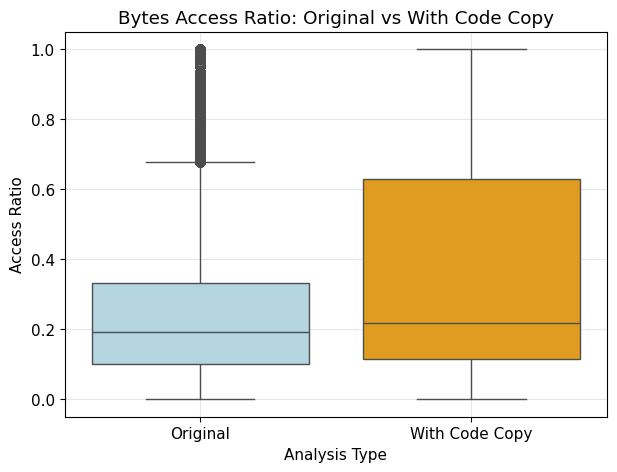

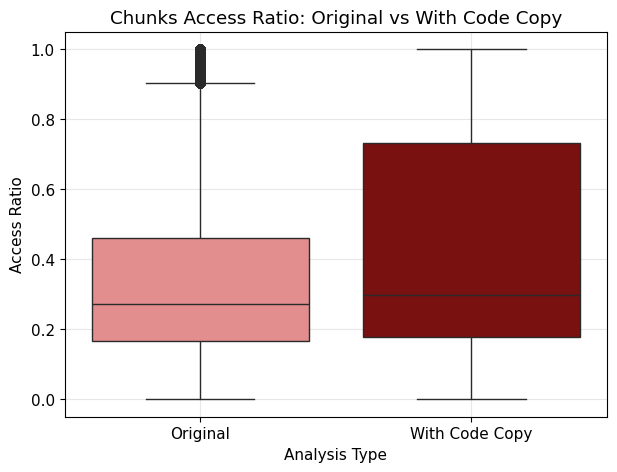

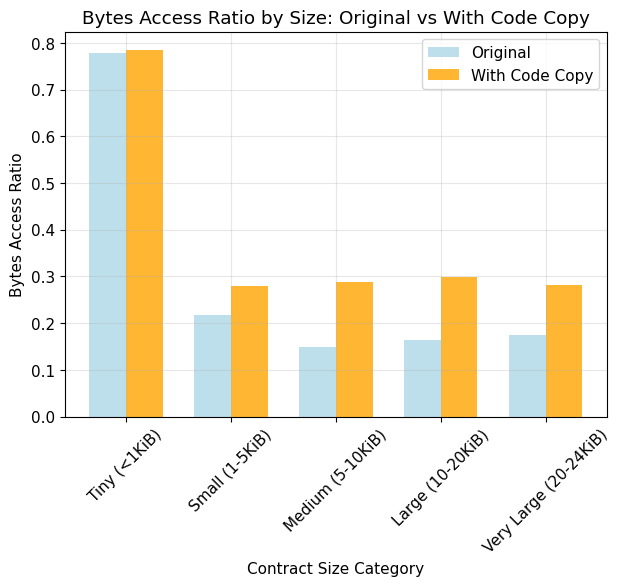

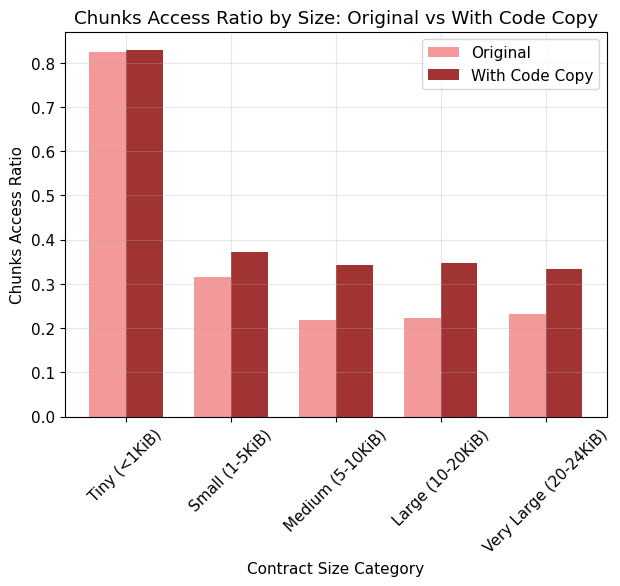


🔍 KEY INSIGHTS - Code Copy Operations Impact:
• Contracts with code copy operations effectively have 100% access ratios
• 10.4% of contracts have code copy operations
• Code copy operations increase average bytes access from 30.0% to 38.6%
• Code copy operations increase average chunks access from 36.8% to 44.7%
• The impact varies significantly by contract size

EFFICIENCY RECLASSIFICATION (considering code copy operations):
• High efficiency (>50% access): 725,666 contracts (29.5%)
• Medium efficiency (20-50% access): 646,008 contracts (26.3%)
• Low efficiency (<20% access): 1,088,647 contracts (44.2%)


In [47]:
# Question 3b: Impact of Code Copy Operations on Access Patterns
# Each code copy operation (CODECOPY) accesses the entire bytecode

print("QUESTION 3b: Impact of Code Copy Operations on Access Patterns")
print("="*70)
print("Note: Each code size hash operation accesses the ENTIRE bytecode (all chunks)")
print()

# Calculate adjusted access ratios considering code size hash operations
# If code_size_hash_count > 0, then effectively ALL bytes and chunks are accessed at least once
df_analysis['adjusted_cc_bytes_ratio'] = df_analysis.apply(
    lambda row: 1.0 if row['code_copy_count'] > 0 else row['bytes_accessed_ratio'], axis=1
)

df_analysis['adjusted_cc_chunks_ratio'] = df_analysis.apply(
    lambda row: 1.0 if row['code_copy_count'] > 0 else row['chunks_accessed_ratio'], axis=1
)

# Compare original vs adjusted ratios
print("COMPARISON: Original vs Code-Copy-Adjusted Access Ratios")
print("-" * 60)

original_bytes_mean = df_analysis['bytes_accessed_ratio'].mean()
adjusted_bytes_mean = df_analysis['adjusted_cc_bytes_ratio'].mean()
original_chunks_mean = df_analysis['chunks_accessed_ratio'].mean()
adjusted_chunks_mean = df_analysis['adjusted_cc_chunks_ratio'].mean()

print(f"BYTES ACCESS RATIOS:")
print(f"• Original average: {original_bytes_mean:.1%}")
print(f"• Adjusted average (considering code copy ops): {adjusted_bytes_mean:.1%}")
print(f"• Increase due to code copy ops: {adjusted_bytes_mean - original_bytes_mean:.1%}")

print(f"\nCHUNKS ACCESS RATIOS:")
print(f"• Original average: {original_chunks_mean:.1%}")
print(f"• Adjusted average (considering code copy ops): {adjusted_chunks_mean:.1%}")
print(f"• Increase due to code copy ops: {adjusted_chunks_mean - original_chunks_mean:.1%}")

# Analysis by contract size
print(f"\nIMPACT BY CONTRACT SIZE CATEGORY:")
print("-" * 40)

size_comparison = df_analysis.groupby('size_category').agg({
    'bytes_accessed_ratio': 'mean',
    'adjusted_cc_bytes_ratio': 'mean',
    'chunks_accessed_ratio': 'mean', 
    'adjusted_cc_chunks_ratio': 'mean',
    'code_copy_count': ['mean', lambda x: (x > 0).mean()]
}).round(3)

size_comparison.columns = ['Original_Bytes', 'Adjusted_Bytes', 'Original_Chunks', 'Adjusted_Chunks', 'Avg_Code_Ops', 'Pct_With_Code_Ops']

for size_cat in size_category_labels:
    if size_cat in size_comparison.index:
        orig_bytes = size_comparison.loc[size_cat, 'Original_Bytes']
        adj_bytes = size_comparison.loc[size_cat, 'Adjusted_Bytes']
        orig_chunks = size_comparison.loc[size_cat, 'Original_Chunks']
        adj_chunks = size_comparison.loc[size_cat, 'Adjusted_Chunks']
        pct_with_ops = size_comparison.loc[size_cat, 'Pct_With_Code_Ops']
        
        bytes_increase = adj_bytes - orig_bytes
        chunks_increase = adj_chunks - orig_chunks
        
        print(f"{size_cat}:")
        print(f"  • {pct_with_ops:.1%} have code copy operations")
        print(f"  • Bytes ratio: {orig_bytes:.1%} → {adj_bytes:.1%} (+{bytes_increase:.1%})")
        print(f"  • Chunks ratio: {orig_chunks:.1%} → {adj_chunks:.1%} (+{chunks_increase:.1%})")

# Visualization
# 1. Before vs After comparison - Bytes (colored box plots)
plt.figure(figsize=(7, 5))
bytes_comparison_df = pd.DataFrame({
    'Access_Ratio': list(df_analysis['bytes_accessed_ratio']) + list(df_analysis['adjusted_cc_bytes_ratio']),
    'Type': ['Original'] * len(df_analysis) + ['With Code Copy'] * len(df_analysis)
})
sns.boxplot(data=bytes_comparison_df, x='Type', y='Access_Ratio', palette=['lightblue', 'orange'])
plt.title('Bytes Access Ratio: Original vs With Code Copy')
plt.xlabel('Analysis Type')
plt.ylabel('Access Ratio')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Before vs After comparison - Chunks (colored box plots)
plt.figure(figsize=(7, 5))
chunks_comparison_df = pd.DataFrame({
    'Access_Ratio': list(df_analysis['chunks_accessed_ratio']) + list(df_analysis['adjusted_cc_chunks_ratio']),
    'Type': ['Original'] * len(df_analysis) + ['With Code Copy'] * len(df_analysis)
})
sns.boxplot(data=chunks_comparison_df, x='Type', y='Access_Ratio', palette=['lightcoral', 'darkred'])
plt.title('Chunks Access Ratio: Original vs With Code Copy')
plt.xlabel('Analysis Type')
plt.ylabel('Access Ratio')
plt.grid(True, alpha=0.3)
plt.show()

# 3. Impact by contract size - Bytes
plt.figure(figsize=(7, 5))
size_means_orig = df_analysis.groupby('size_category')['bytes_accessed_ratio'].mean().reindex(size_category_labels)
size_means_adj = df_analysis.groupby('size_category')['adjusted_cc_bytes_ratio'].mean().reindex(size_category_labels)
x_pos = range(len(size_category_labels))
width = 0.35
plt.bar([x - width/2 for x in x_pos], size_means_orig, width, label='Original', alpha=0.8, color='lightblue')
plt.bar([x + width/2 for x in x_pos], size_means_adj, width, label='With Code Copy', alpha=0.8, color='orange')
plt.xlabel('Contract Size Category')
plt.ylabel('Bytes Access Ratio')
plt.title('Bytes Access Ratio by Size: Original vs With Code Copy')
plt.xticks(x_pos, size_category_labels, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Impact by contract size - Chunks
plt.figure(figsize=(7, 5))
size_means_orig_chunks = df_analysis.groupby('size_category')['chunks_accessed_ratio'].mean().reindex(size_category_labels)
size_means_adj_chunks = df_analysis.groupby('size_category')['adjusted_cc_chunks_ratio'].mean().reindex(size_category_labels)
plt.bar([x - width/2 for x in x_pos], size_means_orig_chunks, width, label='Original', alpha=0.8, color='lightcoral')
plt.bar([x + width/2 for x in x_pos], size_means_adj_chunks, width, label='With Code Copy', alpha=0.8, color='darkred')
plt.xlabel('Contract Size Category')
plt.ylabel('Chunks Access Ratio')
plt.title('Chunks Access Ratio by Size: Original vs With Code Copy')
plt.xticks(x_pos, size_category_labels, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Key insights
print(f"\n🔍 KEY INSIGHTS - Code Copy Operations Impact:")
print(f"• Contracts with code copy operations effectively have 100% access ratios")
print(f"• {(df_analysis['code_copy_count'] > 0).mean():.1%} of contracts have code copy operations")
print(f"• Code copy operations increase average bytes access from {original_bytes_mean:.1%} to {adjusted_bytes_mean:.1%}")
print(f"• Code copy operations increase average chunks access from {original_chunks_mean:.1%} to {adjusted_chunks_mean:.1%}")
print(f"• The impact varies significantly by contract size")

# Efficiency reclassification
high_eff_adj = (df_analysis['adjusted_cc_bytes_ratio'] > 0.5) & (df_analysis['adjusted_cc_chunks_ratio'] > 0.5)
medium_eff_adj = ((df_analysis['adjusted_cc_bytes_ratio'] > 0.2) & (df_analysis['adjusted_cc_chunks_ratio'] > 0.2)) & ~high_eff_adj
low_eff_adj = ~high_eff_adj & ~medium_eff_adj

print(f"\nEFFICIENCY RECLASSIFICATION (considering code copy operations):")
print(f"• High efficiency (>50% access): {high_eff_adj.sum():,} contracts ({high_eff_adj.mean():.1%})")
print(f"• Medium efficiency (20-50% access): {medium_eff_adj.sum():,} contracts ({medium_eff_adj.mean():.1%})")
print(f"• Low efficiency (<20% access): {low_eff_adj.sum():,} contracts ({low_eff_adj.mean():.1%})")

### Question 4: Block-level Analysis

QUESTION 4: Block-level Bytecode Utilization Analysis
Focus: Efficiency classification with and without code operation impact

1. BLOCK-LEVEL EFFICIENCY OVERVIEW:
----------------------------------------
• Blocks analyzed: 9,993
• Average bytes efficiency (original): 16.8%
• Average bytes efficiency (adjusted): 52.1%
• Average chunks efficiency (original): 23.0%
• Average chunks efficiency (adjusted): 55.7%

2. BYTES EFFICIENCY CLASSIFICATION:
----------------------------------------
• Low efficiency blocks:
  - Original: 9,818 (98.2%)
  - Adjusted: 2 (0.0%)
• Medium efficiency blocks:
  - Original: 175 (1.8%)
  - Adjusted: 2,983 (29.9%)
• High efficiency blocks:
  - Original: 0 (0.0%)
  - Adjusted: 7,008 (70.1%)

3. CHUNKS EFFICIENCY CLASSIFICATION:
----------------------------------------
• Low efficiency blocks:
  - Original: 564 (5.6%)
  - Adjusted: 1 (0.0%)
• Medium efficiency blocks:
  - Original: 9,429 (94.4%)
  - Adjusted: 1,030 (10.3%)
• High efficiency blocks:
  - Original: 0

<Figure size 700x500 with 0 Axes>

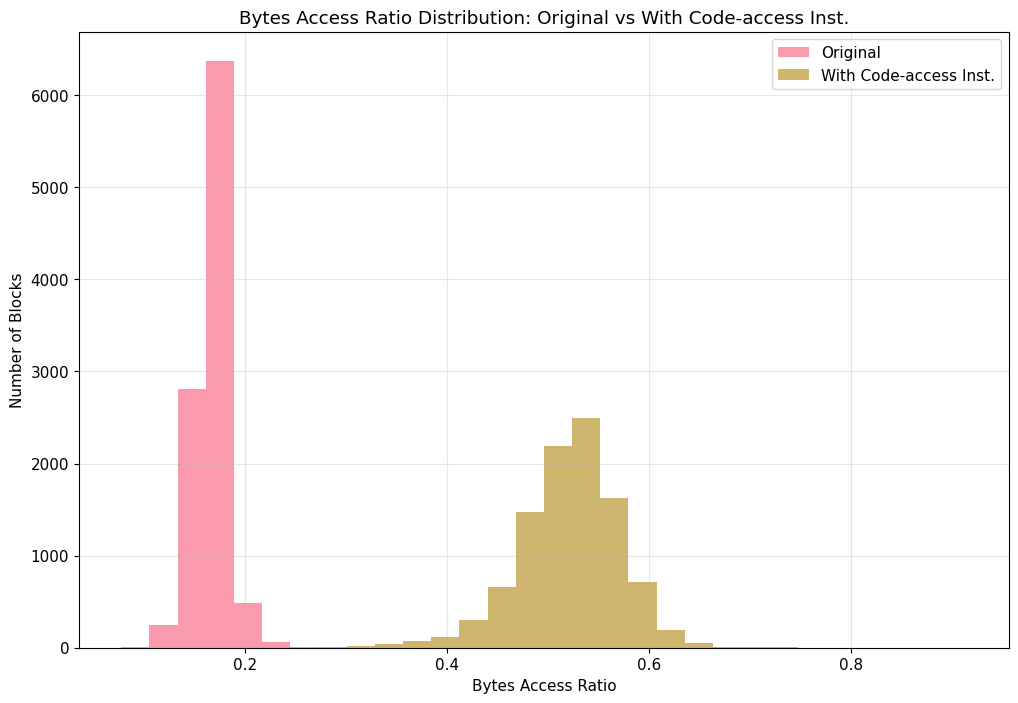

<Figure size 700x500 with 0 Axes>

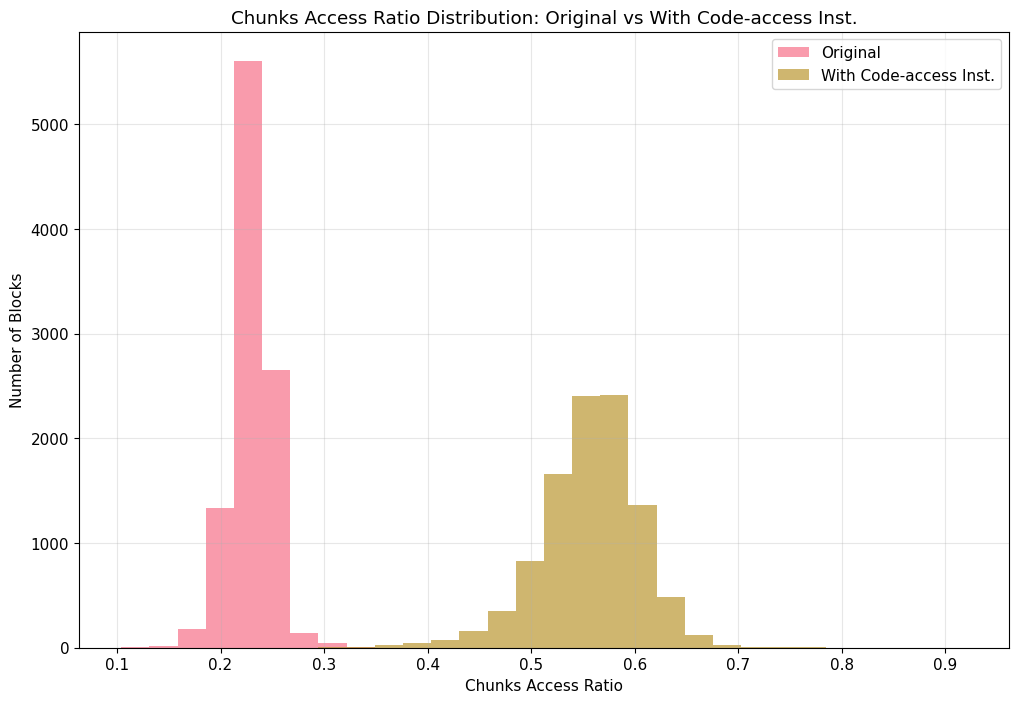


🔍 KEY INSIGHTS - Block-level Bytecode Utilization:
• Code operations significantly shift efficiency classifications
• 9991 blocks see >10% bytes efficiency improvement
• 9990 blocks see >10% chunks efficiency improvement
• Efficiency patterns show clear impact of code operation density per block
• Both bytes and chunks efficiency follow similar patterns but with different magnitudes


In [51]:
# Question 4: Block-level Bytecode Utilization Analysis
print("QUESTION 4: Block-level Bytecode Utilization Analysis")
print("="*70)
print("Focus: Efficiency classification with and without code operation impact")
print()

# Basic block-level aggregations
block_analysis = df_analysis.groupby('block_number').agg({
    'address': ['count', 'nunique'],  # Total calls vs unique contracts
    'bytecode_size': 'sum',
    'bytes_count': 'sum',
    'chunks_count': 'sum', 
    'total_chunks': 'sum',
    'bytes_accessed_ratio': 'mean',
    'chunks_accessed_ratio': 'mean',
    'adjusted_bytes_ratio': 'mean',
    'adjusted_chunks_ratio': 'mean',
    'code_ops_count': 'sum'
}).round(4)

# Flatten column names
block_analysis.columns = [
    'Total_Contract_Calls', 'Unique_Contracts', 'Total_Bytecode_Size',
    'Total_Bytes_Accessed', 'Total_Chunks_Accessed', 'Total_Chunks_Available',
    'Avg_Bytes_Ratio', 'Avg_Chunks_Ratio', 
    'Avg_Adj_Bytes_Ratio', 'Avg_Adj_Chunks_Ratio', 'Total_Code_Ops'
]

# Calculate block-level efficiency metrics
block_analysis['Bytes_Efficiency_Original'] = block_analysis['Total_Bytes_Accessed'] / block_analysis['Total_Bytecode_Size']
block_analysis['Chunks_Efficiency_Original'] = block_analysis['Total_Chunks_Accessed'] / block_analysis['Total_Chunks_Available']

# For adjusted efficiency, we need to calculate how much would be accessed if code ops access everything
adjusted_bytes_accessed = df_analysis.groupby('block_number').apply(
    lambda group: sum(row['bytecode_size'] if row['code_ops_count'] > 0 else row['bytes_count'] 
                     for _, row in group.iterrows())
).reindex(block_analysis.index)

adjusted_chunks_accessed = df_analysis.groupby('block_number').apply(
    lambda group: sum(row['total_chunks'] if row['code_ops_count'] > 0 else row['chunks_count'] 
                     for _, row in group.iterrows())
).reindex(block_analysis.index)

block_analysis['Bytes_Efficiency_Adjusted'] = adjusted_bytes_accessed / block_analysis['Total_Bytecode_Size']
block_analysis['Chunks_Efficiency_Adjusted'] = adjusted_chunks_accessed / block_analysis['Total_Chunks_Available']

# Classification thresholds
HIGH_THRESHOLD = 0.5
LOW_THRESHOLD = 0.2

# Efficiency Classifications - Original (without code ops impact)
block_analysis['Bytes_Class_Original'] = pd.cut(
    block_analysis['Bytes_Efficiency_Original'],
    bins=[0, LOW_THRESHOLD, HIGH_THRESHOLD, 1.0],
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)

block_analysis['Chunks_Class_Original'] = pd.cut(
    block_analysis['Chunks_Efficiency_Original'],
    bins=[0, LOW_THRESHOLD, HIGH_THRESHOLD, 1.0],
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)

# Efficiency Classifications - Adjusted (with code ops impact)
block_analysis['Bytes_Class_Adjusted'] = pd.cut(
    block_analysis['Bytes_Efficiency_Adjusted'],
    bins=[0, LOW_THRESHOLD, HIGH_THRESHOLD, 1.0],
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)

block_analysis['Chunks_Class_Adjusted'] = pd.cut(
    block_analysis['Chunks_Efficiency_Adjusted'],
    bins=[0, LOW_THRESHOLD, HIGH_THRESHOLD, 1.0],
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)

print("1. BLOCK-LEVEL EFFICIENCY OVERVIEW:")
print("-" * 40)
print(f"• Blocks analyzed: {len(block_analysis):,}")
print(f"• Average bytes efficiency (original): {block_analysis['Bytes_Efficiency_Original'].mean():.1%}")
print(f"• Average bytes efficiency (adjusted): {block_analysis['Bytes_Efficiency_Adjusted'].mean():.1%}")
print(f"• Average chunks efficiency (original): {block_analysis['Chunks_Efficiency_Original'].mean():.1%}")
print(f"• Average chunks efficiency (adjusted): {block_analysis['Chunks_Efficiency_Adjusted'].mean():.1%}")

print(f"\n2. BYTES EFFICIENCY CLASSIFICATION:")
print("-" * 40)
bytes_orig_counts = block_analysis['Bytes_Class_Original'].value_counts()
bytes_adj_counts = block_analysis['Bytes_Class_Adjusted'].value_counts()

for category in ['Low', 'Medium', 'High']:
    orig_count = bytes_orig_counts.get(category, 0)
    adj_count = bytes_adj_counts.get(category, 0)
    orig_pct = orig_count / len(block_analysis) * 100
    adj_pct = adj_count / len(block_analysis) * 100
    print(f"• {category} efficiency blocks:")
    print(f"  - Original: {orig_count:,} ({orig_pct:.1f}%)")
    print(f"  - Adjusted: {adj_count:,} ({adj_pct:.1f}%)")

print(f"\n3. CHUNKS EFFICIENCY CLASSIFICATION:")
print("-" * 40)
chunks_orig_counts = block_analysis['Chunks_Class_Original'].value_counts()
chunks_adj_counts = block_analysis['Chunks_Class_Adjusted'].value_counts()

for category in ['Low', 'Medium', 'High']:
    orig_count = chunks_orig_counts.get(category, 0)
    adj_count = chunks_adj_counts.get(category, 0)
    orig_pct = orig_count / len(block_analysis) * 100
    adj_pct = adj_count / len(block_analysis) * 100
    print(f"• {category} efficiency blocks:")
    print(f"  - Original: {orig_count:,} ({orig_pct:.1f}%)")
    print(f"  - Adjusted: {adj_count:,} ({adj_pct:.1f}%)")

print(f"\n4. CODE OPERATIONS IMPACT:")
print("-" * 40)
blocks_with_code_ops = (block_analysis['Total_Code_Ops'] > 0).sum()
print(f"• Blocks with code operations: {blocks_with_code_ops:,} ({blocks_with_code_ops/len(block_analysis):.1%})")
print(f"• Average code operations per block: {block_analysis['Total_Code_Ops'].mean():.1f}")

# Calculate efficiency improvements due to code ops
bytes_improvement = block_analysis['Bytes_Efficiency_Adjusted'] - block_analysis['Bytes_Efficiency_Original']
chunks_improvement = block_analysis['Chunks_Efficiency_Adjusted'] - block_analysis['Chunks_Efficiency_Original']

print(f"• Average bytes efficiency improvement: {bytes_improvement.mean():.1%}")
print(f"• Average chunks efficiency improvement: {chunks_improvement.mean():.1%}")

# Create focused visualizations (adjusted to 1x2 layout since 4 plots were removed)
# 1. Efficiency distribution comparison - Bytes
plt.figure(figsize=(7, 5))
efficiency_comparison_bytes = pd.DataFrame({
    'Original': block_analysis['Bytes_Efficiency_Original'],
    'With Code-access Inst.': block_analysis['Bytes_Efficiency_Adjusted']
})
efficiency_comparison_bytes.plot(kind='hist', alpha=0.7, bins=30)
plt.xlabel('Bytes Access Ratio')
plt.ylabel('Number of Blocks')
plt.title('Bytes Access Ratio Distribution: Original vs With Code-access Inst.')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Efficiency distribution comparison - Chunks
plt.figure(figsize=(7, 5))
efficiency_comparison_chunks = pd.DataFrame({
    'Original': block_analysis['Chunks_Efficiency_Original'],
    'With Code-access Inst.': block_analysis['Chunks_Efficiency_Adjusted']
})
efficiency_comparison_chunks.plot(kind='hist', alpha=0.7, bins=30)
plt.xlabel('Chunks Access Ratio')
plt.ylabel('Number of Blocks')
plt.title('Chunks Access Ratio Distribution: Original vs With Code-access Inst.')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n🔍 KEY INSIGHTS - Block-level Bytecode Utilization:")
print(f"• Code operations significantly shift efficiency classifications")
print(f"• {(bytes_improvement > 0.1).sum()} blocks see >10% bytes efficiency improvement")
print(f"• {(chunks_improvement > 0.1).sum()} blocks see >10% chunks efficiency improvement")
print(f"• Efficiency patterns show clear impact of code operation density per block")
print(f"• Both bytes and chunks efficiency follow similar patterns but with different magnitudes")